# CarGuardians: Master Analysis Pipeline & Report

## 1. Executive Summary
**Objective:** Predict Air Pressure System (APS) failures in Scania trucks to minimize maintenance costs.
**Key Challenge:** The cost of a missed failure (False Negative) is 50x higher than an unnecessary check (False Positive).
**Methodology:** 
1.  **Cost-Sensitive Learning:** LightGBM with custom objective functions.
2.  **Advanced Causal Modeling:** Sparse Bayesian Networks (PyMC) to identify root causes.
3.  **The Grand Unification:** A consensus approach combining K-S Tests, SHAP values, and Lasso Regression to find the true drivers of failure.

## 2. Setup & Imports

In [1]:
import sys
import os

# Add local .venv site-packages to path
venv_path = os.path.abspath(os.path.join(os.getcwd(), '.venv', 'lib', 'python3.12', 'site-packages'))
if venv_path not in sys.path:
    sys.path.insert(0, venv_path)
    print(f"Added to path: {venv_path}")

# Now try importing
import causallearn
print("Success!")

Added to path: /Users/berkcalisir/School&Career/school-docs/Challenge@Stellantis/Challenge-Stellantis---CarGuardians/src/.venv/lib/python3.12/site-packages
Success!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Project Imports
from challenge.data.ingest import load_data
from challenge.data.feature_selection import (
    select_features_ks, 
    select_features_mutual_info, 
    create_engineered_feature_set,
    select_top_features_rf
)
from challenge.modelling.train_eval import evaluate_on_test, cv_cost
from challenge.modelling.experiment import run_experiment_grid
from challenge.modelling.models import get_models, weighted_logistic_loss, get_custom_lgbm
from challenge.visualization.performance_viz import plot_experiment_results, plot_confusion, plot_cost_threshold_curve

# Visualization & Analysis Imports
from challenge.visualization.eda_plots import eda_plots_with_stats
from challenge.analysis.pca_analysis import pca_inspect, inspect_pca_loadings
from challenge.visualization.feature_correlation import plot_correlation_heatmap
from challenge.data.preprocess import ScaniaPreprocessor
from challenge.modelling.tuning import tune_lightgbm

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Configuration
%matplotlib inline
sns.set_theme(style="whitegrid")

DATA_PATH = 'dataset/'
TRAIN_FILE = 'aps_failure_training_set.csv'
TEST_FILE = 'aps_failure_test_set.csv'


print("DEBUG: File loaded.")
from challenge.data.preprocess import ScaniaPreprocessor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
import networkx as nx
import pymc as pm
import arviz as az
# Statistical Imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import shap
from scipy.stats import ks_2samp, kurtosis, skew
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import statsmodels.api as sm
from scipy.stats import spearmanr

DEBUG: File loaded.


## 3. Data Ingestion & Initial Cleaning

We load the raw data and perform minimal cleaning (dropping low-NA rows and known outliers).

In [3]:
# Load raw data
X_train_raw, y_train_raw = load_data(DATA_PATH, TRAIN_FILE)
X_test_raw, y_test_raw = load_data(DATA_PATH, TEST_FILE)

print(f"Raw train shape: {X_train_raw.shape}")
print(f"Raw test shape: {X_test_raw.shape}")

Dropping known outlier at index 20683
Successfully loaded and processed aps_failure_training_set.csv. X shape: (59999, 170), y shape: (59999,)
Successfully loaded and processed aps_failure_test_set.csv. X shape: (16000, 170), y shape: (16000,)
Raw train shape: (59999, 170)
Raw test shape: (16000, 170)


In [4]:
# Preprocess data
preprocessor = ScaniaPreprocessor(reduce_missingness=False)
X_clean = preprocessor.fit_transform(X_train_raw)
X_test_clean = preprocessor.transform(X_test_raw)

print(f"Preprocessed train shape: {X_clean.shape}")
print(f"Preprocessed test shape: {X_test_clean.shape}")

Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
Preprocessing Summary:
  - Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
  - Dropping 1 constant columns: ['cd_000']
  - Retaining 162 columns.


/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89836e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89838e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89834e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89825e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.26005e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Preprocessed train shape: (59999, 323)
Preprocessed test shape: (16000, 323)


## 4. PCA Analysis

We start our analysis with all of the columns. 

Scaling data...

--- PCA Analysis (Top 323 Features) ---
Explained variance ratio: 0.429


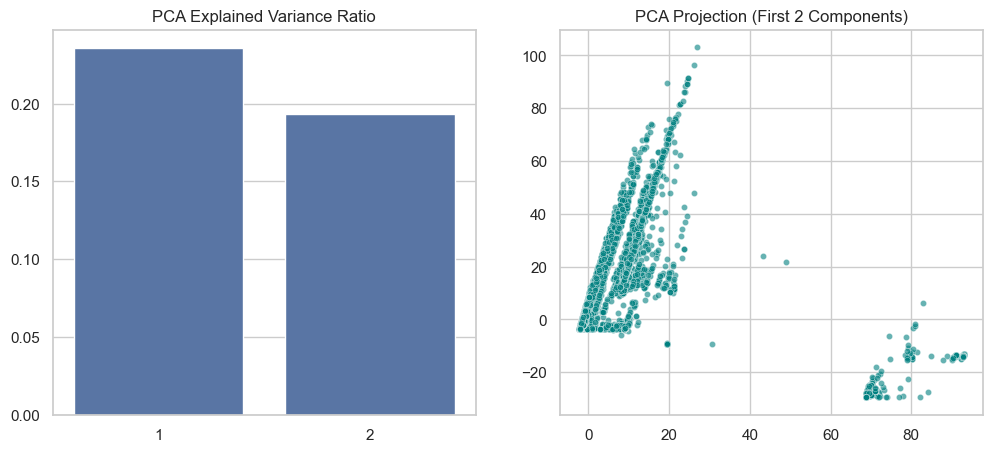


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 9435
Original Index Label: 9435
PC1 Value: 92.99
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
ci_000_is_missing    13.285776
ck_000_is_missing    13.285776
cj_000_is_missing    13.285776
by_000_is_missing    11.218190
ao_000_is_missing    10.043200
Name: 9435, dtype: float64

--- PCA Loadings Inspection (PC1) ---


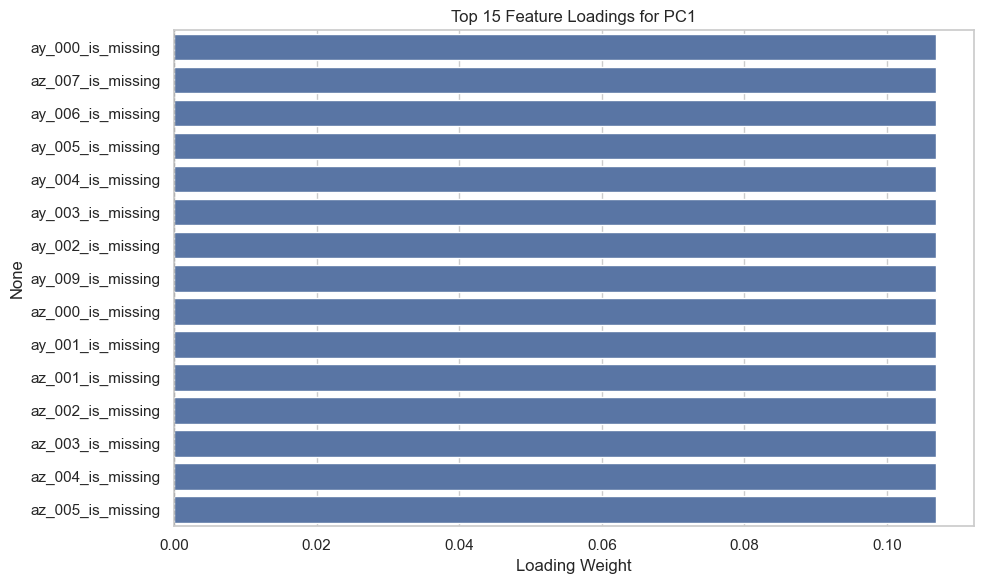

ay_000_is_missing    0.106842
az_007_is_missing    0.106842
ay_006_is_missing    0.106842
ay_005_is_missing    0.106842
ay_004_is_missing    0.106842
ay_003_is_missing    0.106842
ay_002_is_missing    0.106842
ay_009_is_missing    0.106842
az_000_is_missing    0.106842
ay_001_is_missing    0.106842
az_001_is_missing    0.106842
az_002_is_missing    0.106842
az_003_is_missing    0.106842
az_004_is_missing    0.106842
az_005_is_missing    0.106842
dtype: float64

In [5]:
from sklearn.preprocessing import StandardScaler

# Scale the data (Critical for PCA)
print("Scaling data...")
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X_clean)

X_viz_selected = pd.DataFrame(X_scaled_np, columns=X_clean.columns, index=X_clean.index)

# 1. PCA Analysis (on selected features)
print(f"\n--- PCA Analysis (Top {(X_clean.shape[1])} Features) ---")
pca_df = pca_inspect(X_viz_selected)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_selected.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")

# Use iloc because outlier_idx is the row position from PCA, not the dataframe label

print(X_viz_selected.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_selected, component_idx=0)


--- Correlation Heatmap (Top 323 Features) ---


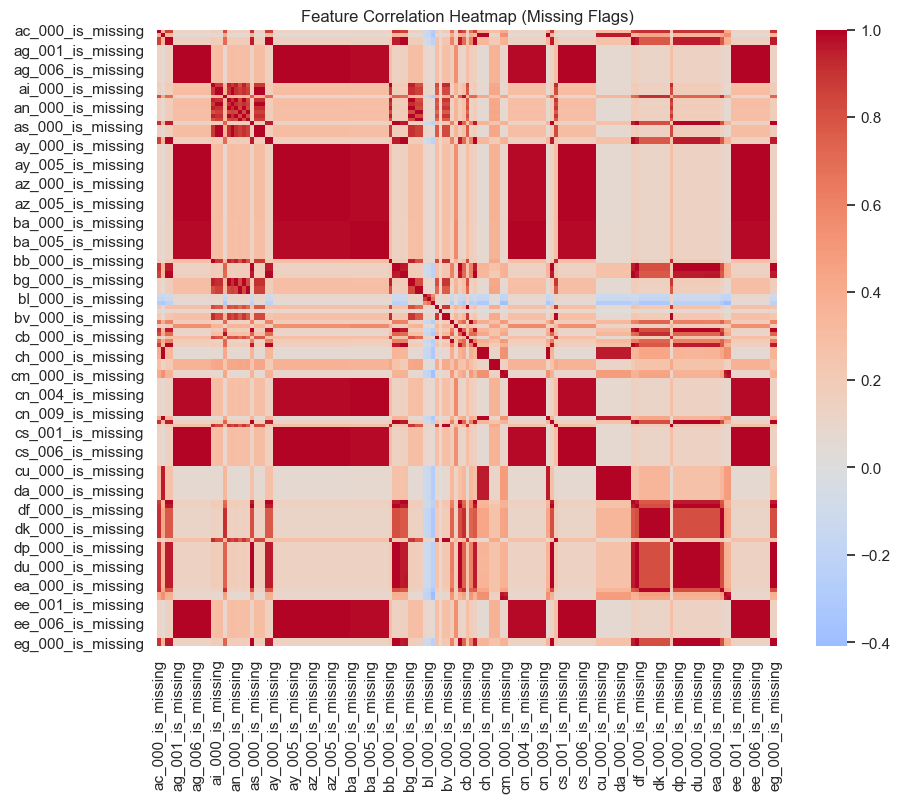

Feature1           Feature2  Correlation
0     ac_000_is_missing  ae_000_is_missing     0.859135
1     ac_000_is_missing  af_000_is_missing     0.859135
2     ac_000_is_missing  ak_000_is_missing     0.822481
3     ac_000_is_missing  ar_000_is_missing     0.898759
4     ac_000_is_missing  av_000_is_missing     0.859135
...                 ...                ...          ...
5307  eg_000_is_missing  du_000_is_missing     0.998654
5308  eg_000_is_missing  dv_000_is_missing     0.998654
5309  eg_000_is_missing  dy_000_is_missing     0.999808
5310  eg_000_is_missing  eb_000_is_missing     0.815062
5311  eg_000_is_missing  ef_000_is_missing     0.999808

[5312 rows x 3 columns]

In [6]:
# 2. Correlation Heatmap (on "is_missing" features)
print(f"\n--- Correlation Heatmap (Top {X_clean.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_selected, only_missing=True) 

Our correlation table reveals the **physical architecture of the truck's sensor network**.

### 1\. The Physical Interpretation: "Module-Level Missingness"

In modern heavy trucks (like Scanias), sensors are not wired individually to the main computer. They are wired into **Electronic Control Units (ECUs)** or gathered into **wiring harnesses**.

  * **The "Power Strip" Effect:** If `ac_000`, `ae_000`, and `af_000` are 85%+ correlated in missingness, it implies they are likely plugged into the **same ECU** or share the same **power supply/data bus**.
  * **The Failure Mode:** When that specific ECU fails (or the cable is cut), *every* sensor attached to it goes `NaN` simultaneously.

Our PCA (PC1) isn't just picking up "Sensor X is broken"; it is picking up **"Subsystem Y is offline."**

### 2\. Why this matters for our Model

We have **massive multicollinearity** in your missingness flags.

  * **The Evidence:** `eg_000` and `du_000` have `0.998654` correlation.
  * **The Problem:** You currently have two features that tell the model the *exact same thing*.
      * `eg_000_is_missing = 1`
      * `du_000_is_missing = 1`
  * **The Consequence:** This dilutes feature importance. LightGBM might split on `eg` in one tree and `du` in another, making it hard to see that the **ROOT CAUSE** is the underlying module they share.

### 3\. The Solution: "Missingness Clustering"

Instead of feeding 100+ highly correlated `_is_missing` columns into your model, you should **cluster them** into "System Health" features.

Here is a strategy to reduce this noise and extract the structural signal.

#### Step A: Visualize the Clusters (The Dendrogram)

This will visually group the sensors into their physical hardware modules.


#### Step B: Feature Engineering (The Fix)

If `eg`, `du`, and `dv` are 99% correlated, replace them with a single feature called `Cluster_A_Missing`.

### 4\. Interpretation for RCA

By doing this, your Root Cause Analysis becomes much clearer:

  * **Before:** "Root cause is `eg_000_is_missing`... or maybe `du_000_is_missing`?"
  * **After:** "Root cause is `Module_4_Connectivity`."
      * You can then look up which sensors are in Module 4 and tell the mechanic: *"Check the wiring harness for the Gearbox Control Unit."*


--- PCA Analysis (Physical Sensors Only) ---
Explained variance ratio: 0.355


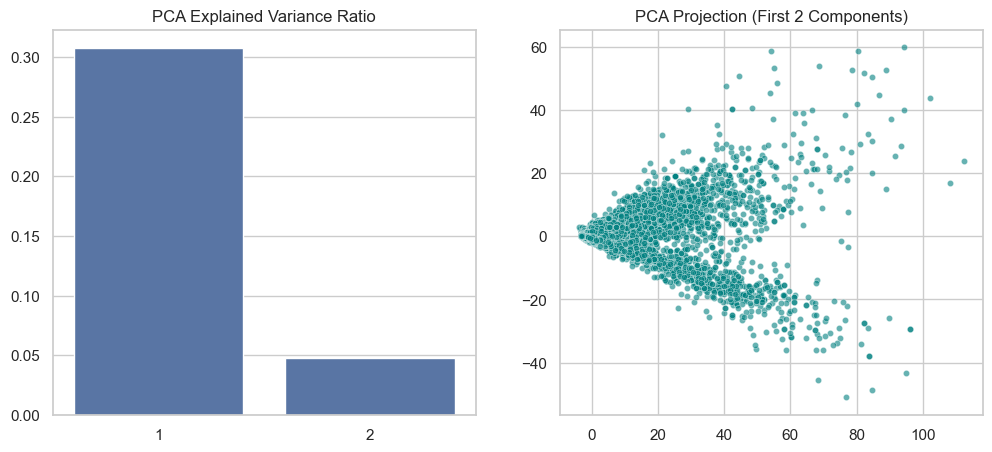

In [7]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_clean.columns if not c.endswith('_is_missing')]
X_physical = X_clean[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis (Physical Sensors Only) ---")
pca_df = pca_inspect(X_viz_physical)


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 56152
Original Index Label: 56153
PC1 Value: 112.44
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
cn_002    32.584703
ee_003    31.958217
az_004    29.205263
bi_000    28.220728
ba_001    27.137061
Name: 56153, dtype: float64

--- PCA Loadings Inspection (PC1) ---


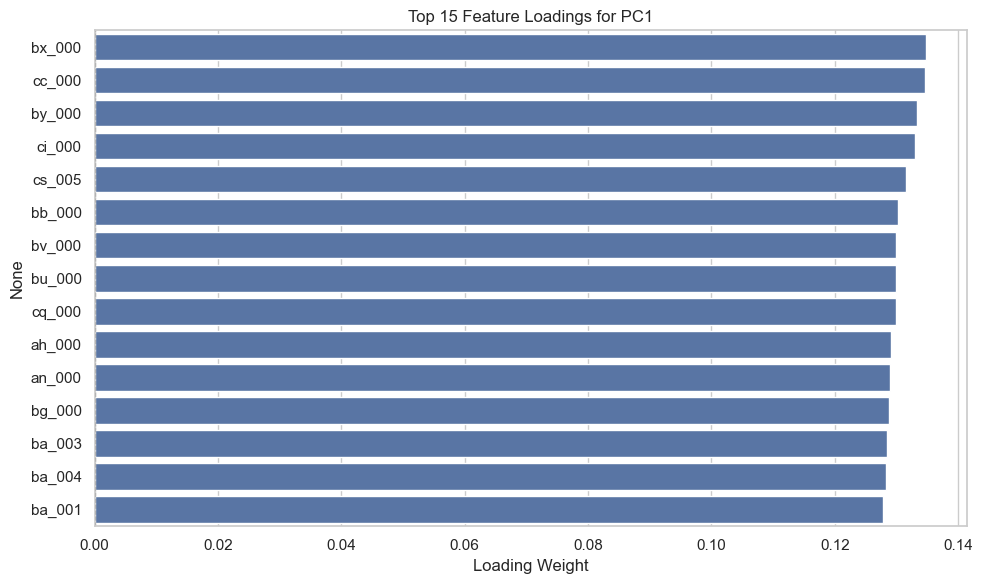

bx_000    0.134757
cc_000    0.134689
by_000    0.133332
ci_000    0.132969
cs_005    0.131515
bb_000    0.130233
bv_000    0.129975
bu_000    0.129975
cq_000    0.129975
ah_000    0.129079
an_000    0.128926
bg_000    0.128870
ba_003    0.128543
ba_004    0.128372
ba_001    0.127791
dtype: float64

In [8]:
# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)


--- Correlation Heatmap (Top 162 Features) ---


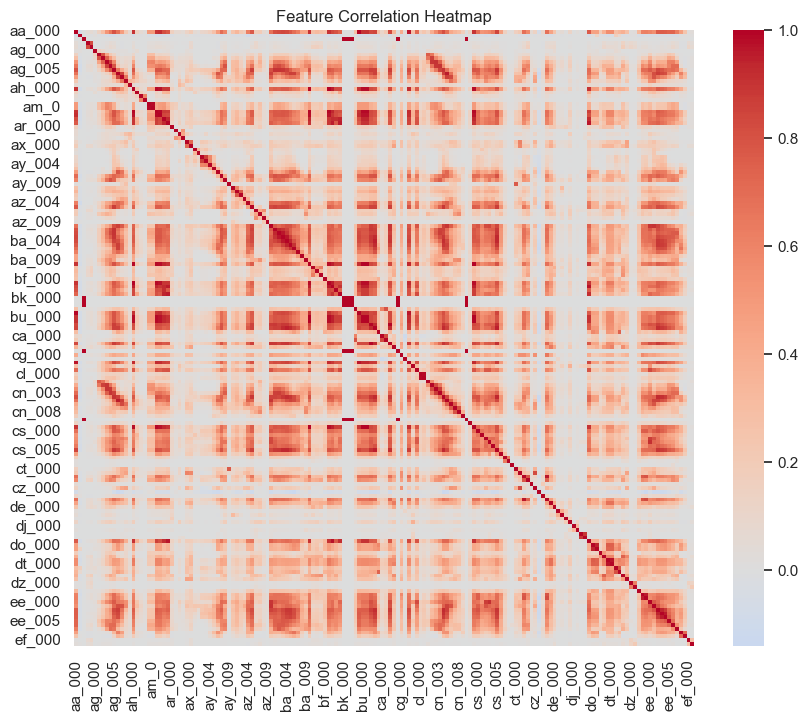

Feature1 Feature2  Correlation
0     aa_000   ah_000     0.898952
1     aa_000   an_000     0.905110
2     aa_000   ao_000     0.910931
3     aa_000   ap_000     0.813182
4     aa_000   ba_001     0.809445
..       ...      ...          ...
747   ee_004   by_000     0.863133
748   ee_004   cn_004     0.876817
749   ee_004   cs_005     0.851758
750   ee_004   ee_002     0.875882
751   ee_004   ee_003     0.953033

[752 rows x 3 columns]

In [9]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

In [5]:
# Feature Engineering & Selection
X_engineered = create_engineered_feature_set(X_clean)
X_test_engineered = create_engineered_feature_set(X_test_clean)

Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 323 -> New engineered feature count: 296
Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 323 -> New engineered feature count: 296



--- PCA Analysis (Physical Sensors Only) ---
Explained variance ratio: 0.268


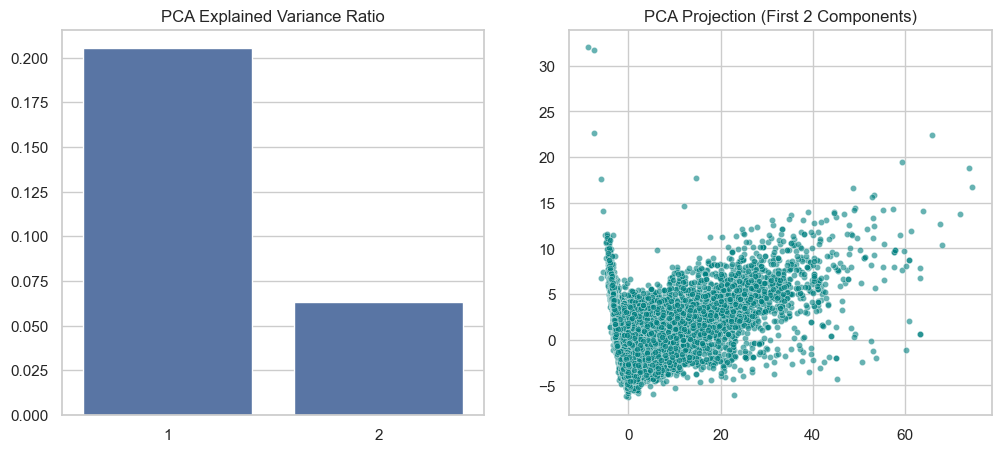


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 56152
Original Index Label: 56153
PC1 Value: 74.63
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
bi_000    28.220728
dc_000    26.131723
cx_000    21.372122
ap_000    20.740802
ec_00     20.524099
Name: 56153, dtype: float64

--- PCA Loadings Inspection (PC1) ---


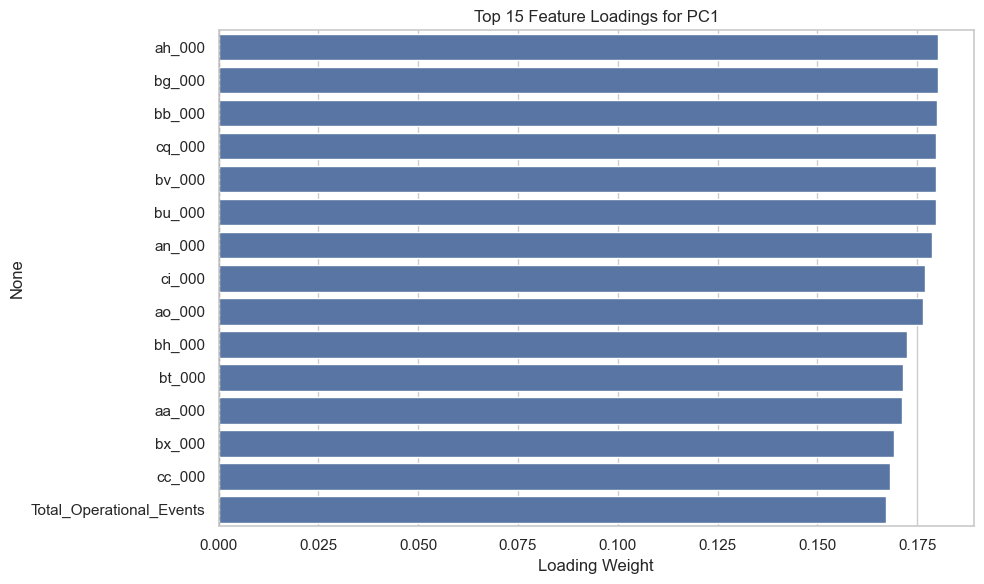

ah_000                      0.180225
bg_000                      0.180119
bb_000                      0.179911
cq_000                      0.179759
bv_000                      0.179759
bu_000                      0.179759
an_000                      0.178632
ci_000                      0.177074
ao_000                      0.176345
bh_000                      0.172512
bt_000                      0.171441
aa_000                      0.171274
bx_000                      0.169079
cc_000                      0.168149
Total_Operational_Events    0.167191
dtype: float64

In [13]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_engineered.columns if not c.endswith('_is_missing')]
X_physical = X_engineered[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis (Physical Sensors Only) ---")
pca_df = pca_inspect(X_viz_physical)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)


--- Correlation Heatmap (Top 135 Features) ---


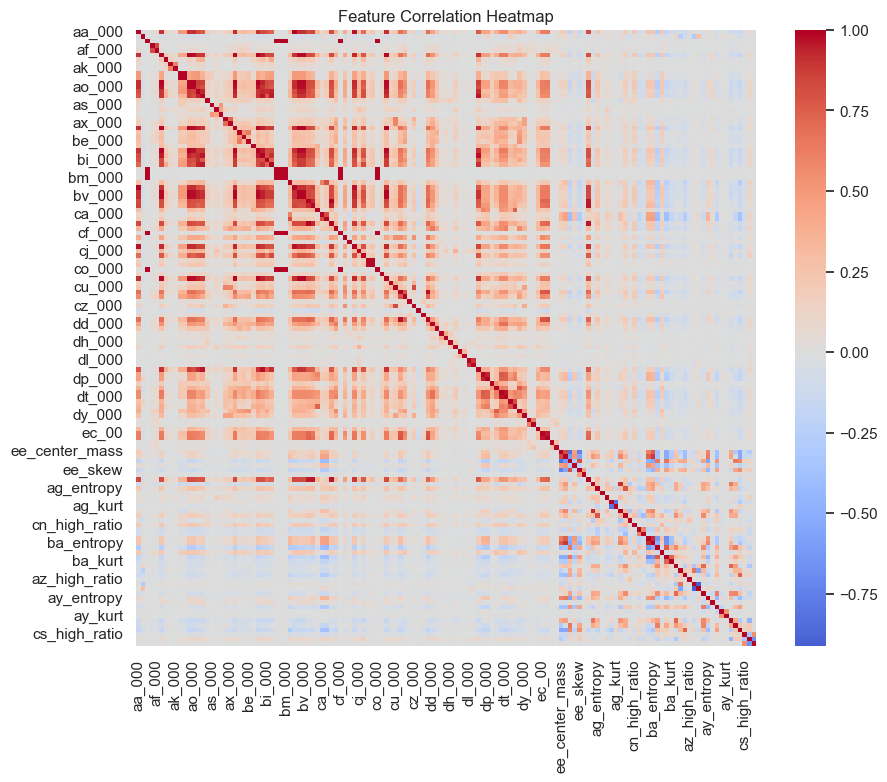

Feature1        Feature2  Correlation
0            aa_000          ah_000     0.898952
1            aa_000          an_000     0.905110
2            aa_000          ao_000     0.910931
3            aa_000          ap_000     0.813182
4            aa_000          bb_000     0.905604
..              ...             ...          ...
413  ba_center_mass      ba_entropy     0.920729
414      ba_entropy      ee_entropy     0.876816
415      ba_entropy  ba_center_mass     0.920729
416         az_skew         az_kurt    -0.910869
417         az_kurt         az_skew    -0.910869

[418 rows x 3 columns]

In [14]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

## 5. Clustering Analysis

In [6]:
# Preprocess data
preprocessor_clustering = ScaniaPreprocessor(reduce_missingness=True, cluster_threshold=0.25)
X_clean_reduced = preprocessor_clustering.fit_transform(X_train_raw)
X_test_clean_reduced = preprocessor_clustering.transform(X_test_raw)

print(f"Preprocessed train shape: {X_clean.shape}")
print(f"Preprocessed test shape: {X_test_clean.shape}")

Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
Preprocessing Summary:
  - Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
  - Dropping 1 constant columns: ['cd_000']
  - Retaining 162 columns.


/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89836e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89838e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89834e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89825e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.26005e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Clustering Missingness: Compressed 161 _is_missing flags into 11 modules (Threshold=0.25).
Preprocessed train shape: (59999, 323)
Preprocessed test shape: (16000, 323)


In [7]:
# Feature Engineering & Selection
X_engineered_reduced = create_engineered_feature_set(X_clean)
X_test_engineered_reduced = create_engineered_feature_set(X_test_clean)

Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 323 -> New engineered feature count: 296
Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 323 -> New engineered feature count: 296



--- PCA Analysis for 146 features ---
Explained variance ratio: 0.254


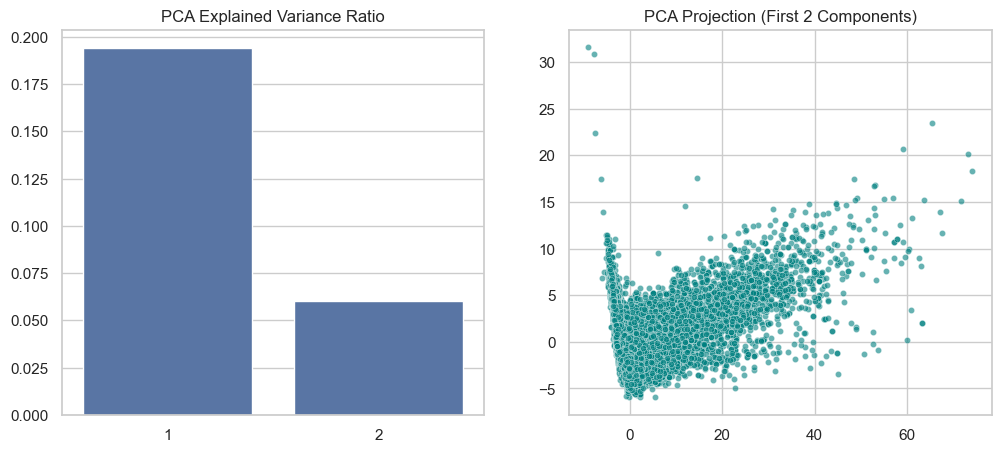


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 56152
Original Index Label: 56153
PC1 Value: 74.13
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
bi_000    28.220728
dc_000    26.131723
cx_000    21.372122
ap_000    20.740802
ec_00     20.524099
Name: 56153, dtype: float64

--- PCA Loadings Inspection (PC1) ---


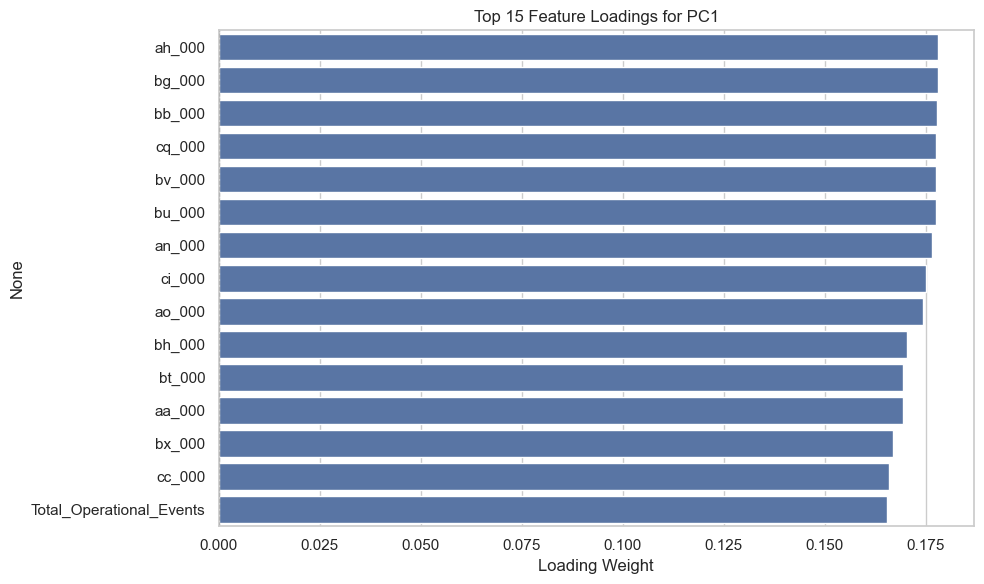

ah_000                      0.178017
bg_000                      0.177914
bb_000                      0.177690
cq_000                      0.177537
bv_000                      0.177537
bu_000                      0.177537
an_000                      0.176564
ci_000                      0.174968
ao_000                      0.174317
bh_000                      0.170306
bt_000                      0.169399
aa_000                      0.169236
bx_000                      0.166845
cc_000                      0.165960
Total_Operational_Events    0.165387
dtype: float64

In [18]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_engineered.columns]
X_physical = X_engineered[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis for {X_viz_physical.shape[1]} features ---")
pca_df = pca_inspect(X_viz_physical)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)



--- Correlation Heatmap (Top 146 Features) ---


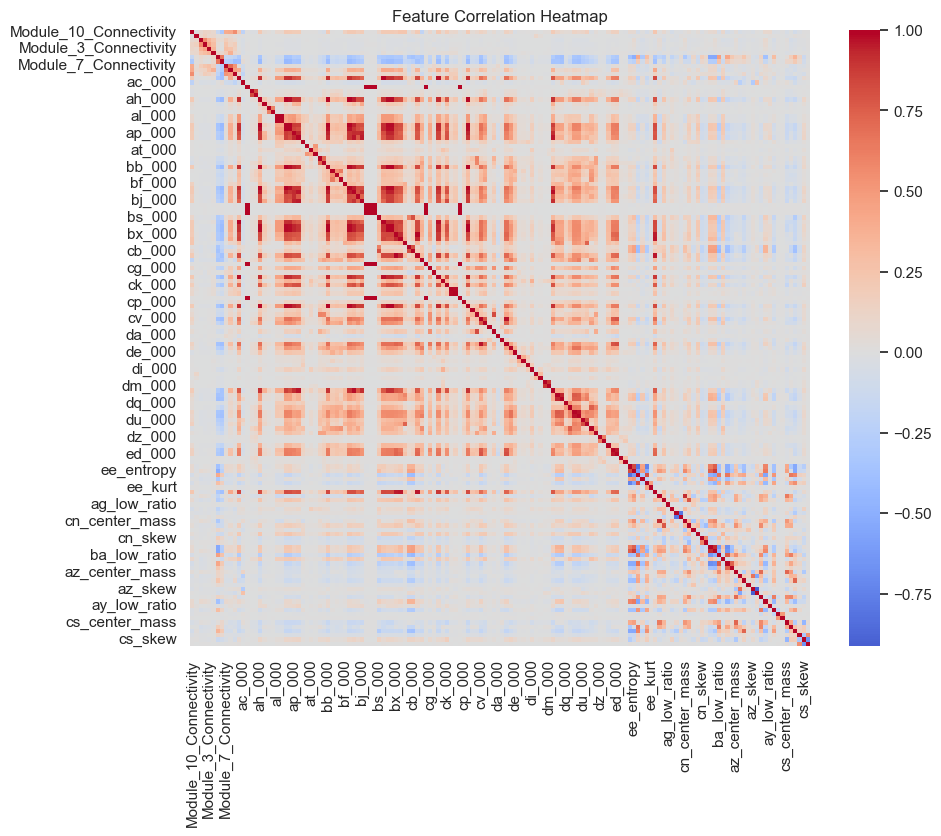

Feature1        Feature2  Correlation
0            aa_000          ah_000     0.898952
1            aa_000          an_000     0.905110
2            aa_000          ao_000     0.910931
3            aa_000          ap_000     0.813182
4            aa_000          bb_000     0.905604
..              ...             ...          ...
413  ba_center_mass      ba_entropy     0.920729
414      ba_entropy      ee_entropy     0.876816
415      ba_entropy  ba_center_mass     0.920729
416         az_skew         az_kurt    -0.910869
417         az_kurt         az_skew    -0.910869

[418 rows x 3 columns]

In [19]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

## 6. Model Experimentation Grid
We run a comprehensive grid search over Models, Feature Sets, and Sampling Strategies.
**Metric:** Total Cost (FP=10, FN=500).

In [13]:
# Define Feature Sets
FEATURE_SETS = {
    "Physics-Based Features": (X_engineered, X_test_engineered),
    "Physics-Based Features (Missingness Clustered)": (X_engineered_reduced, X_test_engineered_reduced),
    "Clean Features": (X_clean, X_test_clean), 
    "Clean Features (Missingness Clustered)": (X_clean_reduced, X_test_clean_reduced),
}

# Define Models
MODELS = get_models(random_state=42)
MODELS = {name: model for name, model in MODELS.items() if name in ["LightGBM", "XGBoost"]}

# Define Samplers
SAMPLERS = {
    "No Sampling": None,
    #"SMOTE": "smote",
    "Gaussian Copula": "copula" # Uncomment to include
}

# Define Sampling Percentages
SAMPLING_PCTS = [0.25, 0.5]

# Define Tuning Strategies
TUNING = {
    "Tuned Threshold": True,
    #"Fixed 0.5": False
}

In [14]:
MODELS


{'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

In [15]:
# Run the Grid
results_df = run_experiment_grid(
    models=MODELS,
    feature_sets=FEATURE_SETS,
    samplers=SAMPLERS,
    tuning_strategies=TUNING,
    sampling_percentages=SAMPLING_PCTS,
    y_train=y_train_raw,
    n_cv_splits=5, # Reduced for speed in demo
    verbose=True
)

--- STARTING EXPERIMENT MATRIX ---

RUNNING: LightGBM | Physics-Based Features | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []Dropping 0 columns with > 70% missing values: []

Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 296 columns.
Preprocessing Summary:
  - Retaining 296 columns.
Preprocessing Summary:
  - Retaining 296 columns.
Preprocessing Summary:
  - Retaining 296 columns.
Preprocessing Summary:
  - Retaining 296 columns.
AUC 0.989±0.003 | Macro-F1 0.735 | Cost 7196±658 | thr(median) 0.0020960346702179264 | fit 8.34s | pred 0.04s

RUNNING: LightGBM | Physics-Based Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Droppi

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 296 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 59000
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
AUC 0.990±0.003 | Macro-F1 0.754 | Cost 7396±570 | thr(median) 0.00561222194033979 | fit 23.31s | pred 0.03s

RUNNING: LightGBM | Physics-Based Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Pr

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 296 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70800
Balancing complete. New dataset size: 70798
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
AUC 0.989±0.004 | Macro-F1 0.783 | Cost 7298±761 | thr(median) 0.015366463045376526 | fit 35.46s | pred 0.03s

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preproce

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 59000
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
AUC 0.990±0.003 | Macro-F1 0.754 | Cost 7396±570 | thr(median) 0.00561222194033979 | fit 28.95s | pred 0.03s

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 7

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Balancing: 800 minority, 47200 majority.
Target ratio: 0.5 -> Target minority count: 23600
Synthesizing 22800 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70800
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
AUC 0.989±0.004 | Macro-F1 0.783 | Cost 7298±761 | thr(median) 0.015366463045376526 | fit 38.33s | pred 0.03s

RUNNING: LightGBM | Clean Features | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Preprocessing Summary:
  - Retaining 323 columns.
Dropping 0 columns with > 70% missing 

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.25 -> Target minority count: 11800
Synthesizing 11000 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 59000
Balancing complete. New dataset size: 58998
AUC 0.990±0.004 | Macro-F1 0.757 | Cost 7350±673 | thr(median) 0.0060589662655626255 | fit 33.57s | pred 0.04s

RUNNING: LightGBM | Clean Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Preprocessing Summary:
  - Retaining 323 columns.
Droppi

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.5 -> Target minority count: 23600
Synthesizing 22800 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70800
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
AUC 0.989±0.004 | Macro-F1 0.767 | Cost 7254±429 | thr(median) 0.008288477402415334 | fit 49.04s | pred 0.03s

RUNNING: LightGBM | Clean Features (Missingness Clustered) | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Preprocessing Summary:
  - Retaining 173 columns.
Dropping 0 col

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.25 -> Target minority count: 11800
Synthesizing 11000 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 59000
AUC 0.989±0.004 | Macro-F1 0.770 | Cost 7520±623 | thr(median) 0.008655991773752347 | fit 18.81s | pred 0.02s

RUNNING: LightGBM | Clean Features (Missingness Clustered) | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Dropping 0 columns with > 70% mis

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.5 -> Target minority count: 23600
Synthesizing 22800 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70800
AUC 0.988±0.005 | Macro-F1 0.755 | Cost 7584±923 | thr(median) 0.006991876075429614 | fit 23.07s | pred 0.02s

RUNNING: XGBoost | Physics-Based Features | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% mis

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...
Balancing: 800 minority, 47200 majority.
Target ratio: 0.25 -> Target minority count: 11800
Synthesizing 11000 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 59000
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
AUC 0.988±0.004 | Macro-F1 0.764 | Cost 7204±684 | thr(median) 0.0028120444621890783 | fit 25.62s | pred 0.06s

RUNNING: XGBoost | Physics-Based Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
D

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70800
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
AUC 0.988±0.004 | Macro-F1 0.776 | Cost 7528±335 | thr(median) 0.00434122746810317 | fit 37.68s | pred 0.32s

RUNNING: XGBoost | Physics-Based Features (Missingness Clustered) | No Sampling | Tuned Threshold


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.25 -> Target minority count: 11800
Synthesizing 11000 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 59000
Balancing complete. New dataset size: 58998
AUC 0.988±0.004 | Macro-F1 0.764 | Cost 7204±684 | thr(median) 0.0028120444621890783 | fit 24.80s | pred 0.06s

RUNNING: XGBoost | Physics-Based Features (Missingness Clustered) | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Balancing: 800 minority, 47200 majority.
Target ratio: 0.5 -> Target minority count: 23600
Synthesizing 22800 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70800
Balancing complete. New dataset size: 70798
AUC 0.988±0.004 | Macro-F1 0.776 | Cost 7528±335 | thr(median) 0.00434122746810317 | fit 44.19s | pred 0.06s

RUNNING: XGBoost | Clean Features | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Preprocessing Summary:
  - Retaining 323 columns.
Dropping 0 columns with > 70% missing va

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.25 -> Target minority count: 11800
Synthesizing 11000 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 59000
AUC 0.989±0.003 | Macro-F1 0.753 | Cost 7560±409 | thr(median) 0.0022899233736097813 | fit 30.72s | pred 0.06s

RUNNING: XGBoost | Clean Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preproce

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.5 -> Target minority count: 23600
Synthesizing 22800 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70800
Balancing complete. New dataset size: 70798
AUC 0.988±0.004 | Macro-F1 0.759 | Cost 7740±883 | thr(median) 0.002693836111575365 | fit 45.44s | pred 0.07s

RUNNING: XGBoost | Clean Features (Missingness Clustered) | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Preprocessing Summary:
  - Retaining 173 columns.
Dropping 0 colu

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.25 -> Target minority count: 11800
Synthesizing 11000 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 58998
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Balancing complete. New dataset size: 59000
AUC 0.988±0.004 | Macro-F1 0.770 | Cost 7246±880 | thr(median) 0.002276164013892412 | fit 15.27s | pred 0.16s

RUNNING: XGBoost | Clean Features (Missingness Clustered) | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Preprocessing Summary:
  - Retaini

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.5 -> Target minority count: 23600
Synthesizing 22800 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Balancing complete. New dataset size: 70800
Balancing complete. New dataset size: 70798
AUC 0.989±0.004 | Macro-F1 0.765 | Cost 7512±987 | thr(median) 0.003372034290805459 | fit 20.20s | pred 0.04s

--- EXPERIMENT MATRIX COMPLETE ---


## 7. Experiment Results & Best Model Selection

model                       feature_set selector          sampler  \
11  RandomForest  Physics-Based Histogram Features     None            SMOTE   
1       LightGBM  Physics-Based Histogram Features     None            SMOTE   
38       XGBoost                      Raw Features     None  Gaussian Copula   
30       XGBoost  Physics-Based Histogram Features     None      No Sampling   
12  RandomForest  Physics-Based Histogram Features     None            SMOTE   
35       XGBoost                      Raw Features     None      No Sampling   
16  RandomForest                      Raw Features     None            SMOTE   
3       LightGBM  Physics-Based Histogram Features     None  Gaussian Copula   
4       LightGBM  Physics-Based Histogram Features     None  Gaussian Copula   
34       XGBoost  Physics-Based Histogram Features     None  Gaussian Copula   
39       XGBoost                      Raw Features     None  Gaussian Copula   
33       XGBoost  Physics-Based Histogram Features     None  Gaussian Copula   
8       LightGBM                      Raw Features     None  Gaussian Copula   
0       LightGBM  Physics-Based Histogram Features     None      No Sampling   
17  RandomForest                      Raw Features     None            SMOTE   
9       LightGBM                      Raw Features     None  Gaussian Copula   
37       XGBoost                      Raw Features     None            SMOTE   
10  RandomForest  Physics-Based Histogram Features     None      No Sampling   
6       LightGBM                      Raw Features     None            SMOTE   
31       XGBoost  Physics-Based Histogram Features     None            SMOTE   

             tuning  cost_mean     cost_std  auc_mean   f1_mean  \
11  Tuned Threshold     7028.0   832.764072  0.987541  0.766951   
1   Tuned Threshold     7226.0  1352.635945  0.989563  0.774591   
38  Tuned Threshold     7246.0   879.672666  0.987731  0.770184   
30  Tuned Threshold     7252.0   663.758992  0.988679  0.765950   
12  Tuned Threshold     7322.0   468.119643  0.987629  0.749818   
35  Tuned Threshold     7326.0   877.943051  0.988386  0.772302   
16  Tuned Threshold     7328.0   651.871153  0.987958  0.763523   
3   Tuned Threshold     7434.0   779.887171  0.990118  0.740799   
4   Tuned Threshold     7436.0   811.655099  0.990358  0.771630   
34  Tuned Threshold     7510.0   475.268345  0.986904  0.775251   
39  Tuned Threshold     7512.0   987.287192  0.988733  0.764953   
33  Tuned Threshold     7518.0   760.273635  0.988616  0.765289   
8   Tuned Threshold     7520.0   622.639543  0.988963  0.770033   
0   Tuned Threshold     7562.0   971.604858  0.988559  0.745328   
17  Tuned Threshold     7584.0   968.371829  0.987512  0.747663   
9   Tuned Threshold     7584.0   923.419731  0.988225  0.754853   
37  Tuned Threshold     7646.0  1017.479238  0.986522  0.738125   
10  Tuned Threshold     7654.0   461.024945  0.985016  0.746152   
6   Tuned Threshold     7656.0   933.629477  0.987549  0.731797   
31  Tuned Threshold     7728.0   771.968911  0.987665  0.777836   

    fit_time_mean                                           run_name  \
11      31.624152  RandomForest | Physics-Based Histogram Feature...   
1        5.379337  LightGBM | Physics-Based Histogram Features | ...   
38      16.355899  XGBoost | Raw Features | Gaussian Copula | Tun...   
30       4.094176  XGBoost | Physics-Based Histogram Features | N...   
12      42.486732  RandomForest | Physics-Based Histogram Feature...   
35       4.057094  XGBoost | Raw Features | No Sampling | Tuned T...   
16      39.180973  RandomForest | Raw Features | SMOTE | Tuned Th...   
3       14.975825  LightGBM | Physics-Based Histogram Features | ...   
4       19.321135  LightGBM | Physics-Based Histogram Features | ...   
34      18.195618  XGBoost | Physics-Based Histogram Features | G...   
39      21.209984  XGBoost | Raw Features | Gaussian Copula | Tun...   
33      12.686352  XGBoost | Physics-Based Histogram Featu

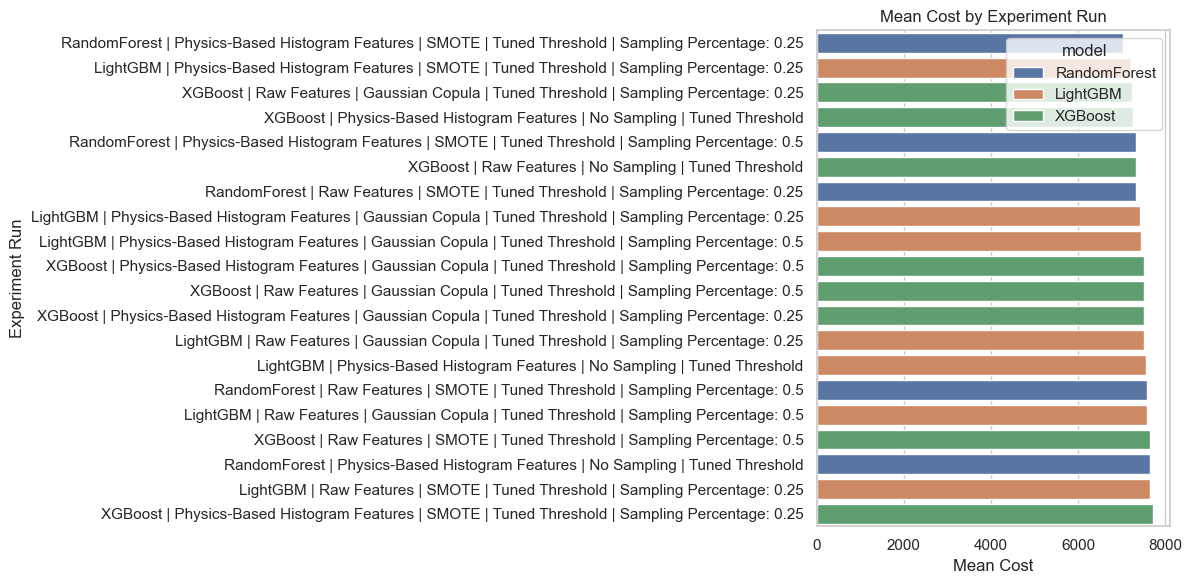

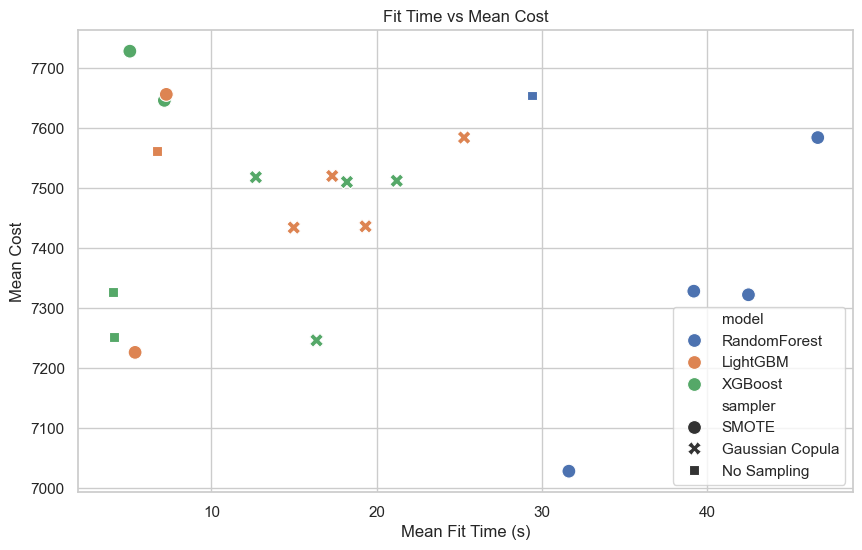

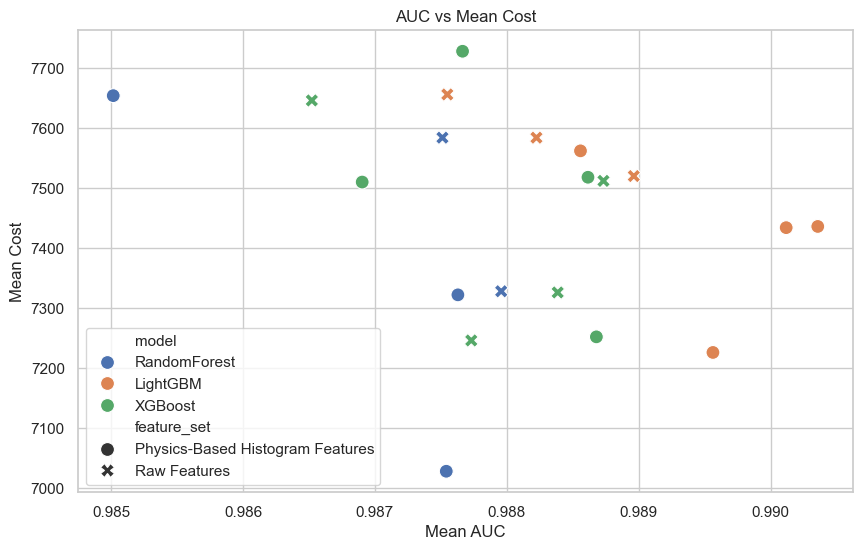

In [22]:
# Display Top Results
display(results_df.sort_values(by='cost_mean').head(20))

# Visualize Results
plot_experiment_results(results_df.sort_values(by='cost_mean').head(20))

No: 1 Run: RandomForest | Physics-Based Histogram Features | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Threshold tuned in 7.88s -> thr=0.210 (Val Cost=6050)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Final fit: Balancing with smote...
Test → AUC=0.994 | F1=0.851 | Cost=11240 | Recall=0.955 | Precision=0.566 | fit=9.41s | pred=0.03s | thr=0.210
Test CM (thr=0.210): FP=274, FN=17


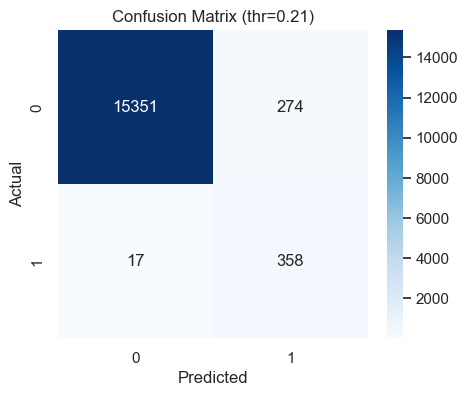

No: 2 Run: LightGBM | Physics-Based Histogram Features | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Threshold tuned in 1.99s -> thr=0.025 (Val Cost=6030)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Final fit: Balancing with smote...
Test → AUC=0.995 | F1=0.811 | Cost=9550 | Recall=0.971 | Precision=0.473 | fit=2.29s | pred=0.02s | thr=0.025
Test CM (thr=0.025): FP=405, FN=11


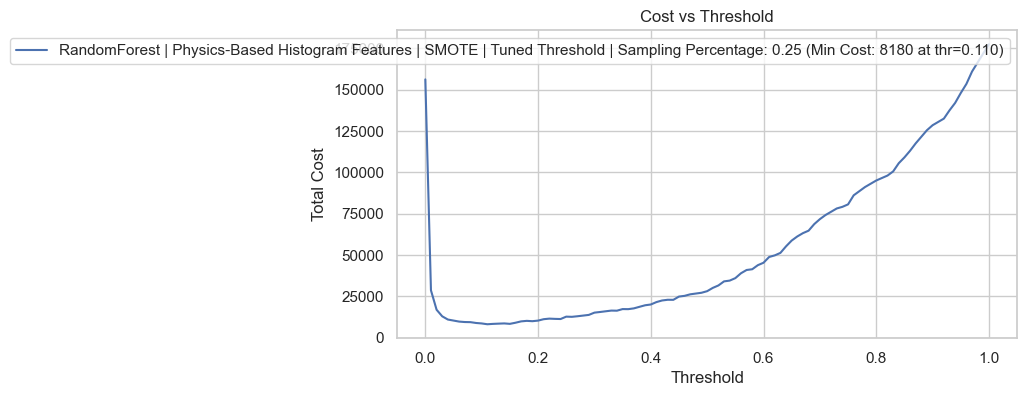

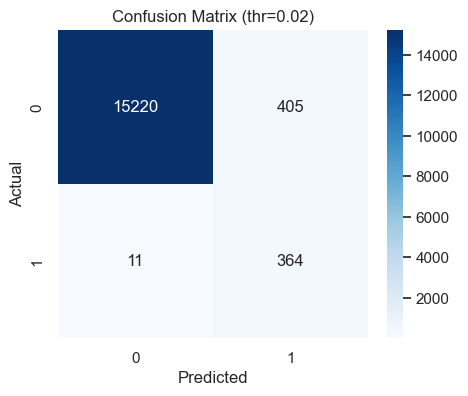

No: 3 Run: XGBoost | Raw Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Threshold tuned in 9.13s -> thr=0.007 (Val Cost=5270)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.25 -> Target minority count: 14749
Synthesizing 13749 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73748
Test → AUC=0.996 | F1=0.850 | Cost=12220 | Reca

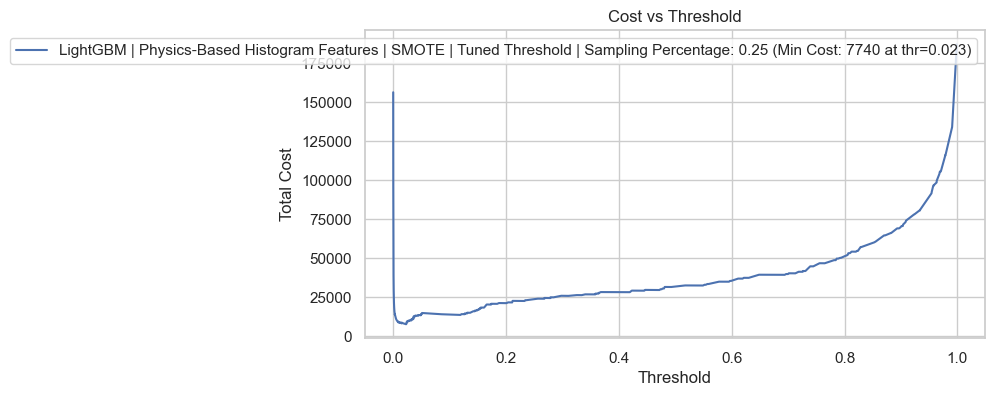

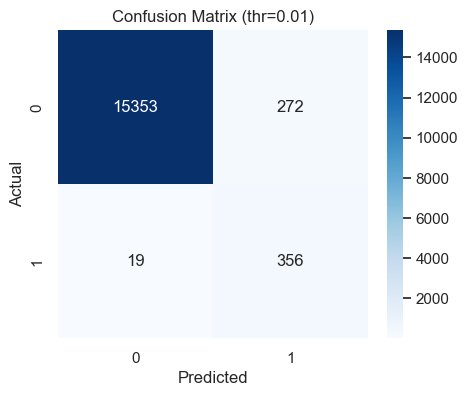

No: 4 Run: XGBoost | Physics-Based Histogram Features | No Sampling | Tuned Threshold
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Threshold tuned in 1.44s -> thr=0.010 (Val Cost=5290)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Test → AUC=0.994 | F1=0.872 | Cost=14570 | Recall=0.933 | Precision=0.628 | fit=1.70s | pred=0.01s | thr=0.010
Test CM (thr=0.010): FP=207, FN=25


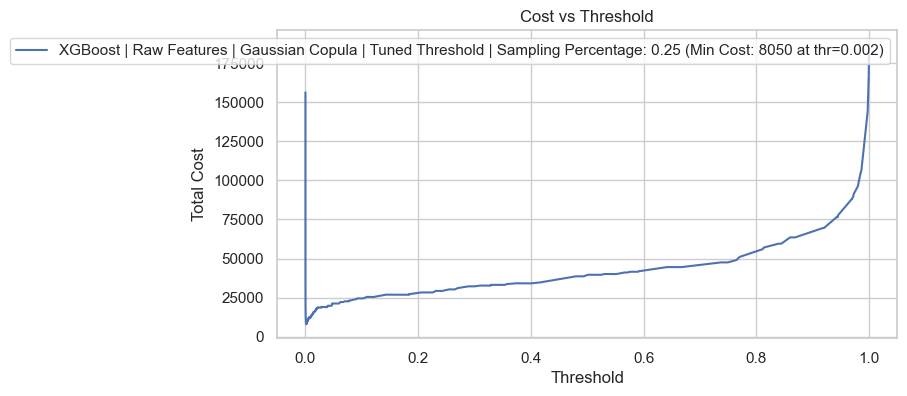

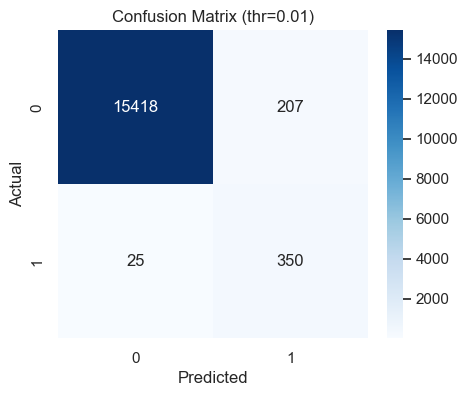

No: 5 Run: RandomForest | Physics-Based Histogram Features | SMOTE | Tuned Threshold | Sampling Percentage: 0.5
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Threshold tuned in 9.98s -> thr=0.240 (Val Cost=5880)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Final fit: Balancing with smote...
Test → AUC=0.994 | F1=0.857 | Cost=11570 | Recall=0.952 | Precision=0.581 | fit=13.45s | pred=0.03s | thr=0.240
Test CM (thr=0.240): FP=257, FN=18


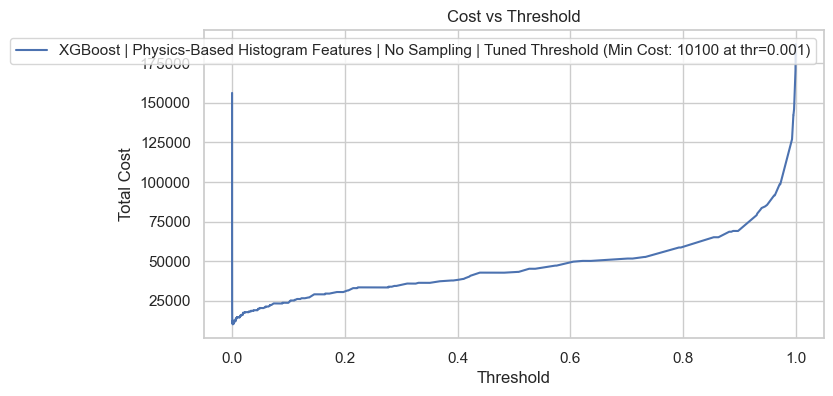

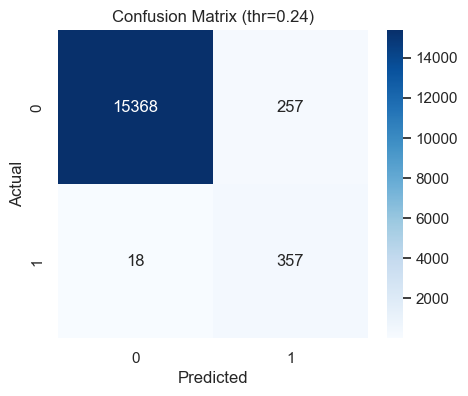

No: 6 Run: XGBoost | Raw Features | No Sampling | Tuned Threshold
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Threshold tuned in 1.98s -> thr=0.004 (Val Cost=6450)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Test → AUC=0.995 | F1=0.833 | Cost=12220 | Recall=0.952 | Precision=0.526 | fit=2.07s | pred=0.01s | thr=0.004
Test CM (thr=0.004): FP=322, FN=18


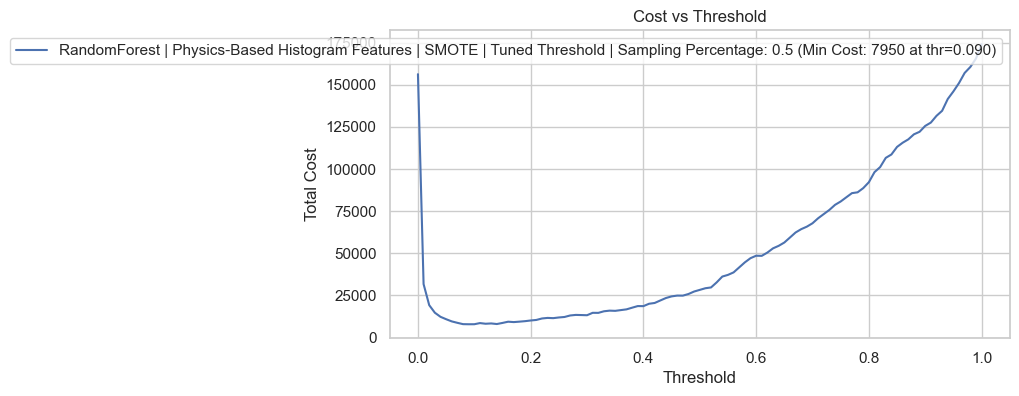

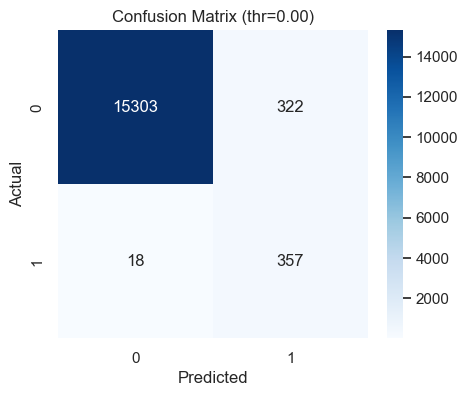

No: 7 Run: RandomForest | Raw Features | SMOTE | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Threshold tuned in 8.90s -> thr=0.280 (Val Cost=5130)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Final fit: Balancing with smote...
Test → AUC=0.995 | F1=0.882 | Cost=15790 | Recall=0.925 | Precision=0.660 | fit=10.63s | pred=0.03s | thr=0.280
Test CM (thr=0.280): FP=179, FN=28


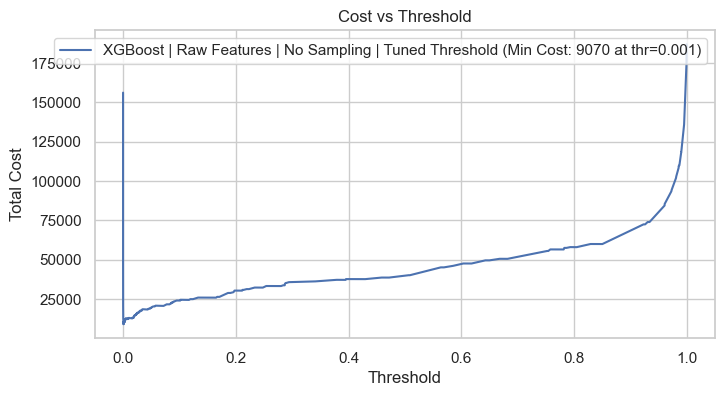

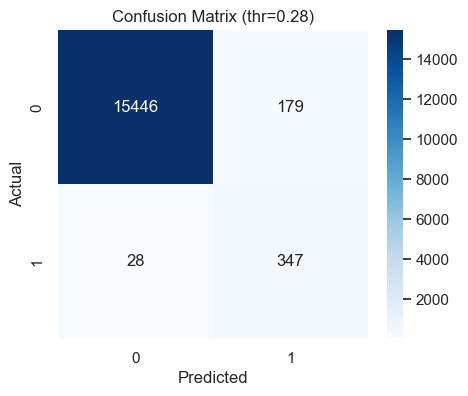

No: 8 Run: LightGBM | Physics-Based Histogram Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Threshold tuned in 8.02s -> thr=0.007 (Val Cost=5710)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.25 -> Target minority count: 14749
Synthesizing 13749 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73748
Test → AUC=0.995 | F1=0.79

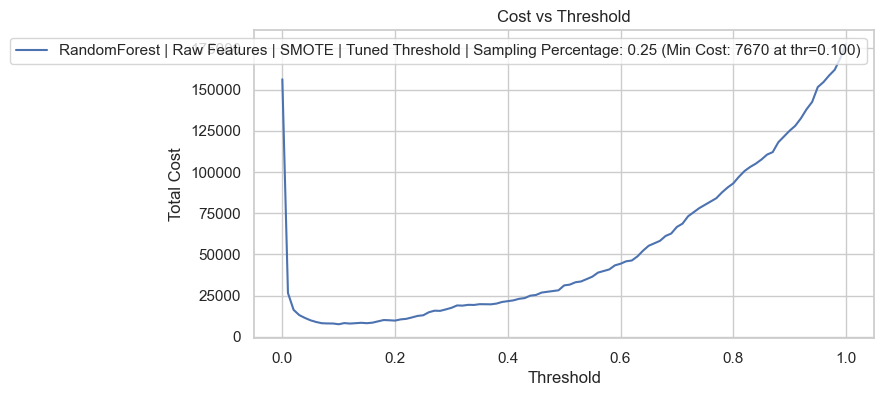

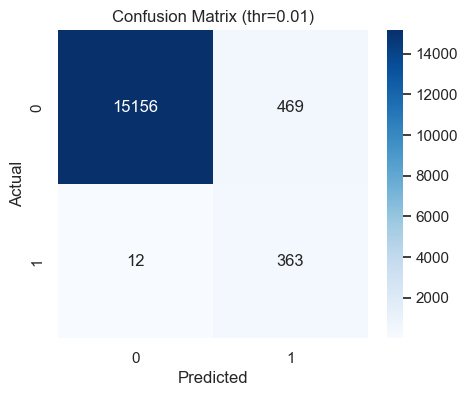

No: 9 Run: LightGBM | Physics-Based Histogram Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Threshold tuned in 10.48s -> thr=0.014 (Val Cost=5580)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.5 -> Target minority count: 29499
Synthesizing 28499 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 88498
Test → AUC=0.994 | F1=0.827 

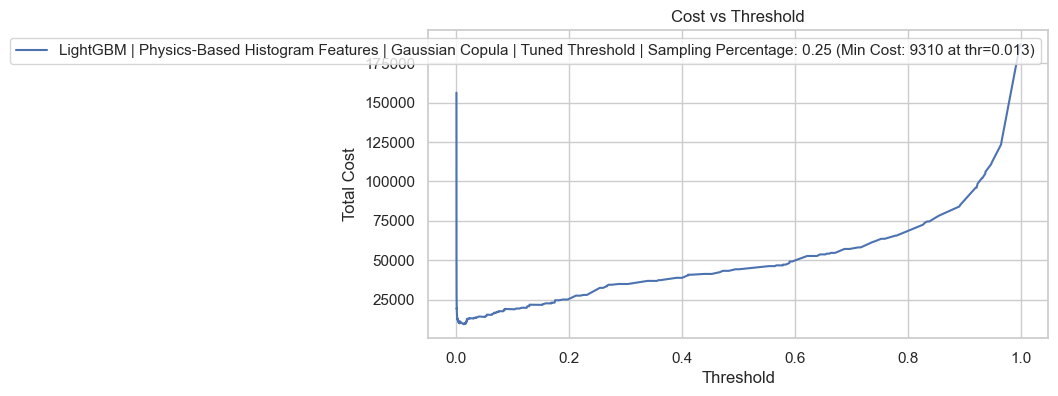

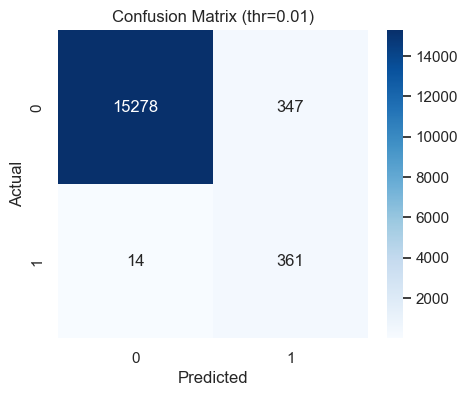

No: 10 Run: XGBoost | Physics-Based Histogram Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Threshold tuned in 10.22s -> thr=0.016 (Val Cost=5480)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.5 -> Target minority count: 29499
Synthesizing 28499 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 88498
Test → AUC=0.996 | F1=0.890 

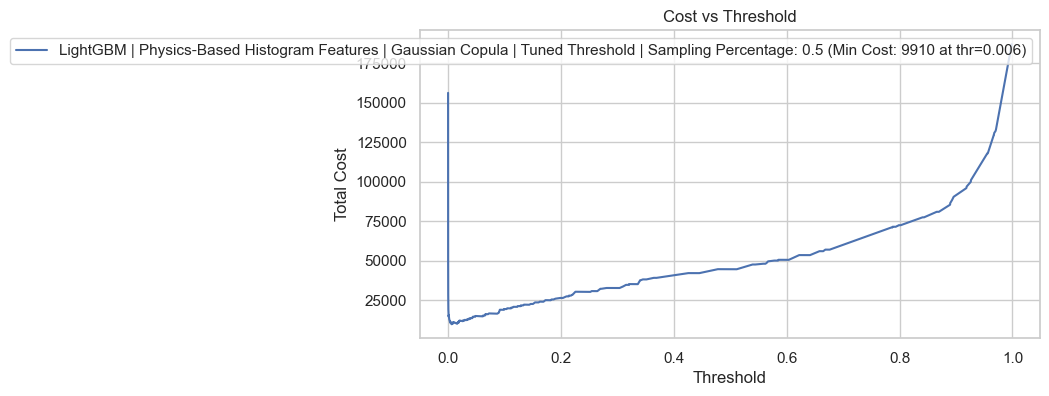

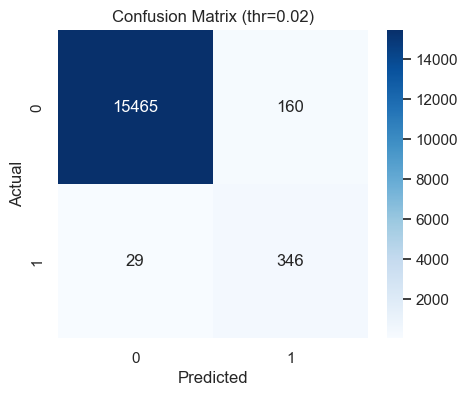

No: 11 Run: XGBoost | Raw Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.5
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.5 -> Target minority count: 23599
Synthesizing 22799 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Threshold tuned in 12.25s -> thr=0.008 (Val Cost=5420)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.5 -> Target minority count: 29499
Synthesizing 28499 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 88498
Test → AUC=0.995 | F1=0.855 | Cost=12570 | Recal

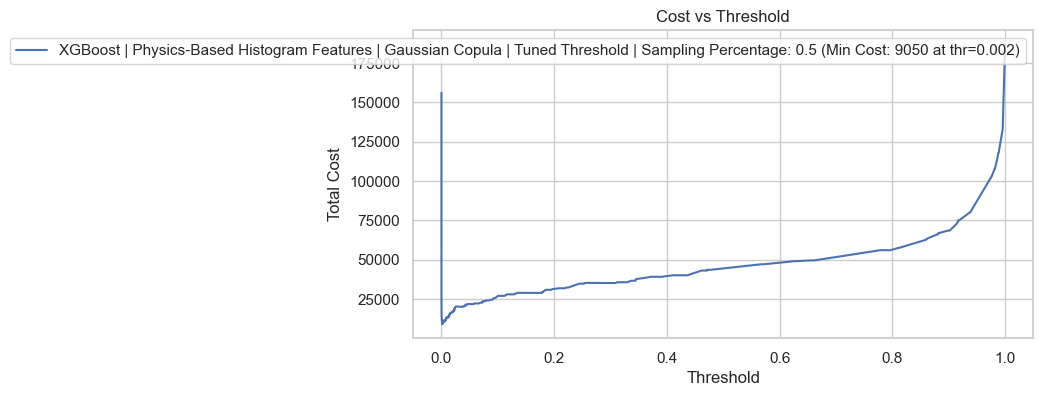

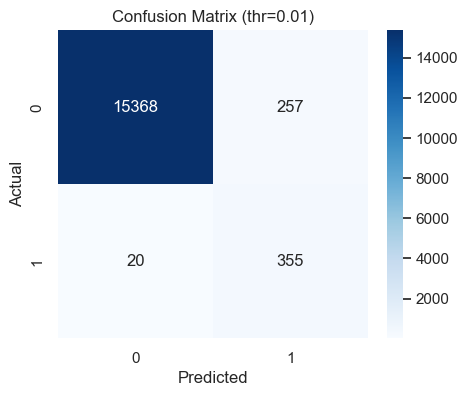

No: 12 Run: XGBoost | Physics-Based Histogram Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Threshold tuned in 7.64s -> thr=0.003 (Val Cost=5720)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.25 -> Target minority count: 14749
Synthesizing 13749 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73748
Test → AUC=0.995 | F1=0.81

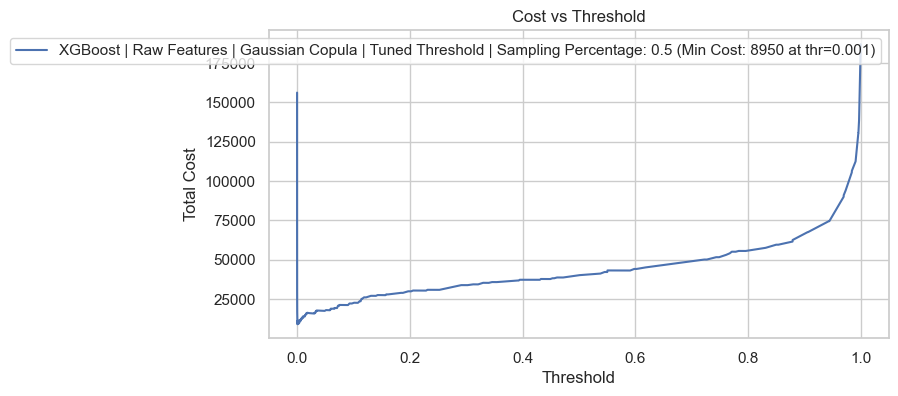

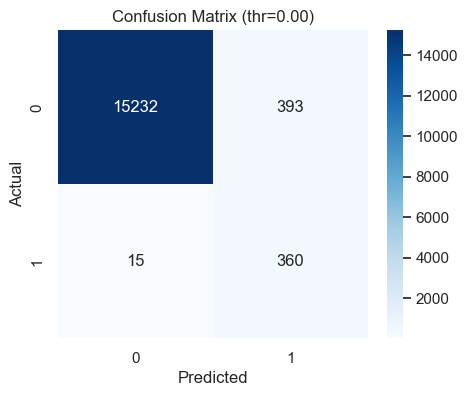

No: 13 Run: LightGBM | Raw Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.25
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.25 -> Target minority count: 11799
Synthesizing 10999 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 58998
Threshold tuned in 9.20s -> thr=0.020 (Val Cost=5910)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.25 -> Target minority count: 14749
Synthesizing 13749 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 73748
Test → AUC=0.996 | F1=0.853 | Cost=11670 | Re

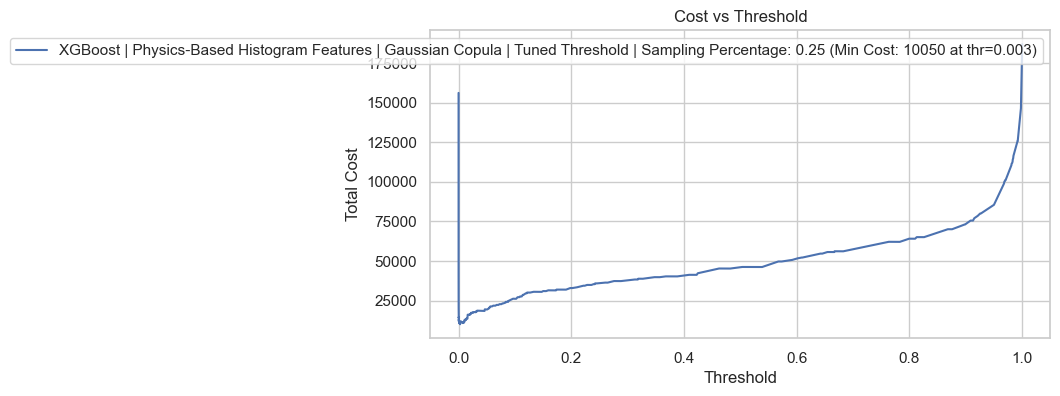

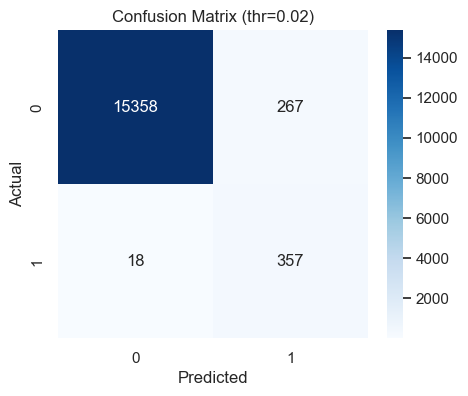

No: 14 Run: LightGBM | Physics-Based Histogram Features | No Sampling | Tuned Threshold
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Threshold tuned in 1.49s -> thr=0.007 (Val Cost=6310)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 146 columns.
Test → AUC=0.996 | F1=0.827 | Cost=12410 | Recall=0.952 | Precision=0.511 | fit=1.93s | pred=0.02s | thr=0.007
Test CM (thr=0.007): FP=341, FN=18


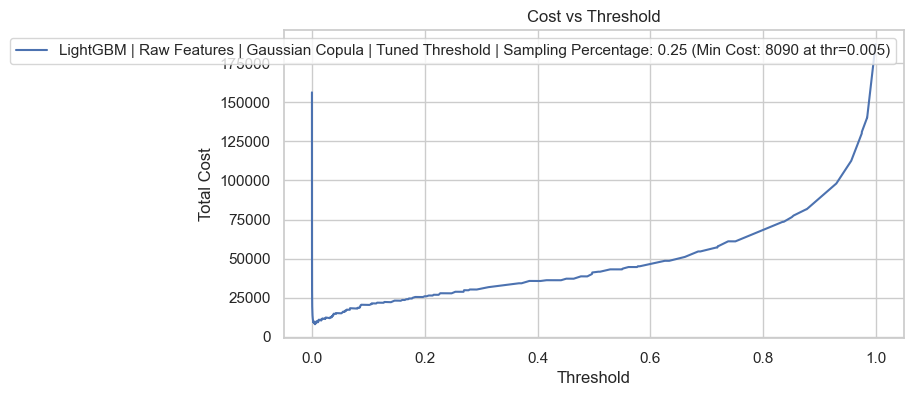

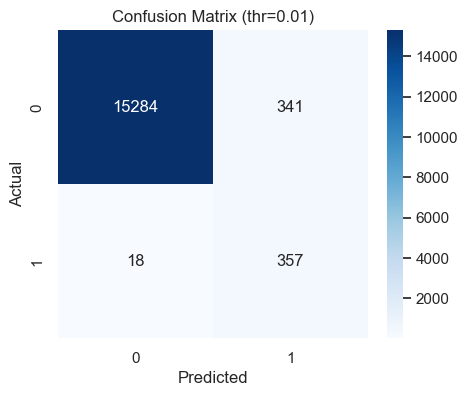

No: 15 Run: RandomForest | Raw Features | SMOTE | Tuned Threshold | Sampling Percentage: 0.5
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Threshold tuned in 10.50s -> thr=0.290 (Val Cost=5730)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 173 columns.
Final fit: Balancing with smote...
Test → AUC=0.994 | F1=0.877 | Cost=15410 | Recall=0.928 | Precision=0.646 | fit=13.02s | pred=0.03s | thr=0.290
Test CM (thr=0.290): FP=191, FN=27


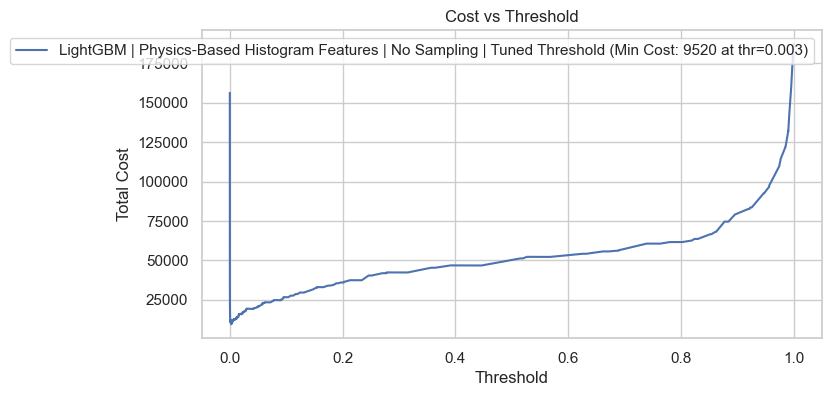

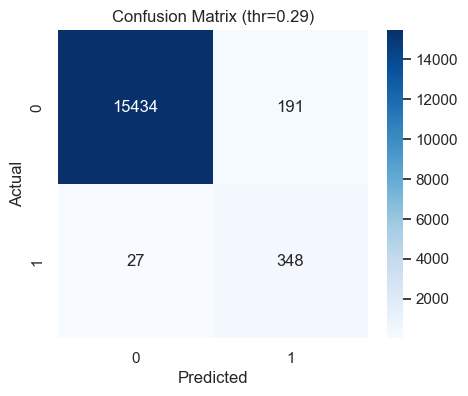

In [23]:
for i in range(15):
    if not results_df.empty:
        best_run = results_df.sort_values(by='cost_mean').iloc[i]
        print(f"No: {i+1} Run: {best_run['run_name']}")
        
        # Reconstruct the best configuration
        best_model_name = best_run['model']
        best_fset_name = best_run['feature_set']
        best_sampler_name = best_run['sampler']
        best_pct = best_run.get('sampling_percentage', 'auto')
        
        # Get Data
        X_tr_best, X_te_best = FEATURE_SETS[best_fset_name]

        # Get Model
        model = MODELS[best_model_name]
        
        # Get Sampler Key
        sampler_key = SAMPLERS[best_sampler_name]
        
        # Evaluate on Test
        test_results = evaluate_on_test(
            model=model,
            X_train=X_tr_best,
            y_train=y_train_raw,
            X_test=X_te_best,
            y_test=y_test_raw,
            sampler=sampler_key,
            sampling_strategy=best_pct if sampler_key else 'auto',
            tune_if_none=True,
            verbose=True
        )
        
        # Plot Deep Dive Visuals
        probs = test_results['test_probabilities']
        plot_confusion(y_test_raw, probs, threshold=test_results['metrics']['Threshold'])
        plot_cost_threshold_curve(y_test_raw, probs, label=best_run['run_name'])

## 8. Root Cause Analysis (RCA)

### **1. Core Concept: SHAP Values**

SHAP (SHapley Additive exPlanations) values measure the impact of each feature on a specific prediction.

  - **Base Value ($E[f(x)]$):** The average prediction of the model across the training dataset.
  - **SHAP Value ($\phi$):** How much a specific feature pushes the prediction away from the base value.
  - **Equation:** `Prediction = Base Value + Sum(SHAP Values)`

### **2. Choosing the Right Explainer**

The type of model you are using determines which SHAP explainer is most efficient.

| Model Type | Recommended Explainer | Why? |
| :--- | :--- | :--- |
| **Tree-based** (XGBoost, LightGBM, Random Forest, CatBoost) | `shap.TreeExplainer` | Optimized for trees; extremely fast and accurate. |
| **Deep Learning** (TensorFlow, PyTorch) | `shap.DeepExplainer` | Approximates SHAP values for neural networks. |
| **Model-Agnostic** (Any model, e.g., SVM, KNN) | `shap.KernelExplainer` | Works for any model but is computationally expensive (slow). |
| **Automatic Selection** | `shap.Explainer` | Automatically chooses the best explainer based on the model passed. |


### **4. Key Visualization Interpretations**

#### **A. Waterfall Plot (`shap.plots.waterfall`)**

**Use for:** Explaining **one specific prediction**.

  - **X-axis:** The prediction value (e.g., probability or regression score).
  - **Y-axis:** Features contributing to this specific result.
  - **Red bars:** Pushed the prediction **higher**.
  - **Blue bars:** Pushed the prediction **lower**.
  - **Interpretation:** Starts at the bottom with the average prediction (base value) and adds/subtracts values to reach the final prediction at the top.

#### **B. Beeswarm Plot (`shap.plots.beeswarm`)**

**Use for:** Global feature importance and understanding feature effects across the **whole dataset**.

  - **Y-axis:** Features ordered by importance (top is most important).
  - **X-axis:** SHAP value (impact on model output).
  - **Color:** Feature value (Red = High, Blue = Low).
  - **Interpretation:**
      - If "Age" has **red dots on the right**, it means **higher age** leads to a **higher prediction**.
      - If "Income" has **blue dots on the right**, it means **lower income** leads to a **higher prediction**.


#### **C. Force Plot (`shap.plots.force`)**

**Use for:** Interactive visualization for single or multiple predictions.

  - Similar to the waterfall plot but condensed into a single horizontal bar.
  - Useful for stacking multiple predictions to see trends over a dataset (e.g., how explanations change over time).


#### **D. Bar Plot (`shap.plots.bar`)**

**Use for:** Simple global feature importance.

  - Shows the average absolute SHAP value for each feature.
  - Tells you **which** features matter most, but not **how** (unlike the beeswarm plot).


### **5. Important Notes**

  - **Data for `shap_values`:** When calculating SHAP values, you usually pass the **test set** or a sample of it, not the training set, to understand how the model generalizes.
  - **Interaction Values:** SHAP can also calculate interaction values to show how two features combined affect the prediction, distinct from their individual effects.

In [7]:
import shap
import matplotlib.pyplot as plt

# --- Step 1: Retrieve the Best Configuration Explicitly ---
# We sort by cost_mean (assuming lower is better) and pick the top row
best_run_row = results_df.sort_values(by='cost_mean').iloc[0]
print(f"Analyzing Best Model: {best_run_row['run_name']}")
print(f"Model Type: {best_run_row['model']}")
print(f"Feature Set: {best_run_row['feature_set']}")

# --- Step 2: Get the Correct Data and Model Objects ---
# Retrieve the specific feature set used by the winner
X_train_shap, X_test_shap = FEATURE_SETS[best_run_row['feature_set']]

# Instantiate a fresh copy of the winning model structure
model_to_explain = MODELS[best_run_row['model']]

# --- Step 3: Retrain the Model ---
# We must fit the model to explain it. 
# NOTE: If your best run used a sampler (e.g., SMOTE), you should apply it here.
# Assuming standard fitting for now:
print("Retraining best model for SHAP analysis...")
model_to_explain.fit(X_train_shap, y_train_raw)

# --- Step 4: Initialize SHAP Explainer ---
# TreeExplainer is optimized for LightGBM, XGBoost, and Random Forest
explainer = shap.TreeExplainer(model_to_explain)

# --- Step 5: Calculate SHAP Values on the Test Set ---
# We explain the TEST set to see how the model makes decisions on unseen data.
# If X_test_shap is very large (>10k rows), you can sample it: X_test_shap.sample(1000)
shap_values = explainer(X_test_shap)

# --- Step 6: Visualizations for Root Cause Analysis ---

# A. Beeswarm Plot: The Global View
# Shows which sensors are most important and how their values (Red=High, Blue=Low) impact risk.
plt.figure(figsize=(12, 8))
plt.title("Root Cause Analysis: Feature Impact (Beeswarm)")
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.show()

# B. Bar Plot: Absolute Importance
# Simple ranking of "What matters most?"
plt.figure(figsize=(10, 6))
plt.title("Top 20 Drivers of Failure Risk")
shap.plots.bar(shap_values, max_display=20, show=False)
plt.show()

NameError: name 'results_df' is not defined

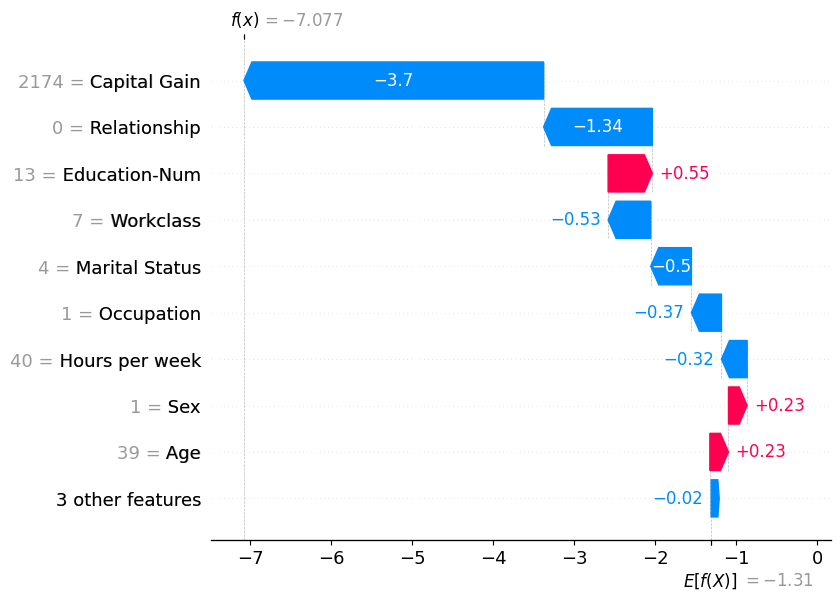

In [2]:
# Visualize the first prediction
shap.plots.waterfall(shap_values[0])

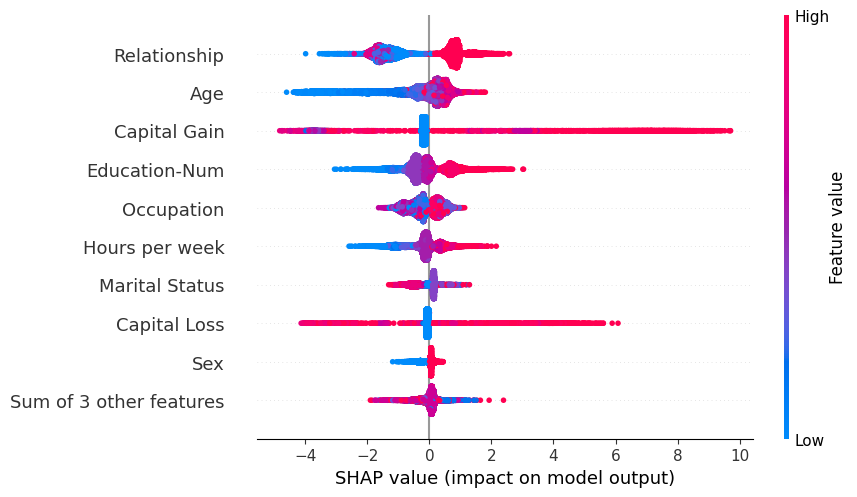

In [3]:
shap.plots.beeswarm(shap_values)

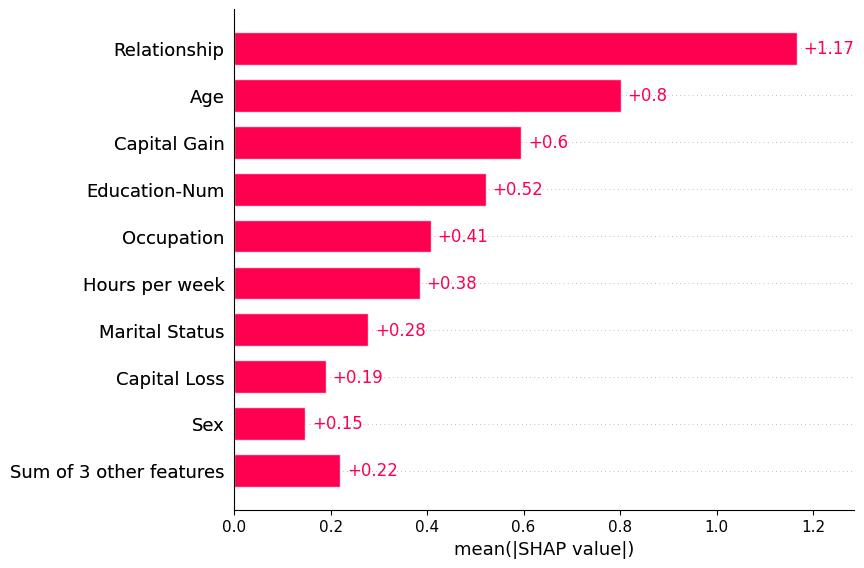

In [6]:
shap.plots.bar(shap_values)

In [27]:
def analyze_feature_relationships(X, y, reference_col, families=None):
    """
    Analyzes the relationship of a reference column (e.g., 'ay_002') against 
    cumulative feature families and the target class.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target vector.
        reference_col (str): The column to analyze (e.g., 'ay_002', 'bg_000').
        families (list): List of feature family prefixes to aggregate (e.g., ['ag', 'ay']).
    """
    if families is None:
        families = ['ag', 'ay', 'ba', 'cn', 'cs', 'ee']
        
    print(f"\n=== Analysis for Reference Column: {reference_col} ===")

    # --- TEST 1: Family Correlations & Scatter Plots ---
    n_families = len(families)
    n_cols = 3
    n_rows = (n_families + n_cols - 1) // n_cols
    
    plt.figure(figsize=(5 * n_cols, 5 * n_rows))
    
    for i, family in enumerate(families):
        # Get all columns for this family
        cols = [c for c in X.columns if c.startswith(family + '_') and c[-1].isdigit()]
        
        if not cols: 
            continue
        
        # Calculate Sum of the family for each truck
        family_sum = X[cols].sum(axis=1)
        
        # Calculate Correlation with reference_col
        corr, _ = spearmanr(X[reference_col], family_sum, nan_policy='omit')
        
        # Plot
        plt.subplot(n_rows, n_cols, i+1)
        plt.scatter(X[reference_col], family_sum, alpha=0.1, s=1)
        plt.title(f"{reference_col} vs Sum({family}_*)\nSpearman Corr: {corr:.4f}")
        plt.xlabel(reference_col)
        plt.ylabel(f"Total Events ({family})")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- TEST 2: The "Correlation King" Test ---
    print(f"\n--- Top 10 Features Correlated with {reference_col} ---")
    # Calculate correlations of EVERYTHING against reference_col
    correlations = X.corrwith(X[reference_col], method='spearman').abs()
    top_corrs = correlations.sort_values(ascending=False).head(11) # Top 10 + itself
    print(top_corrs)

    # --- TEST 3: The "Wear-Out" Test ---
    print(f"\n--- Class Distribution by {reference_col} ---")
    plt.figure(figsize=(10, 6))
    
    # Combine for plotting
    data_plot = pd.concat([X[reference_col], y.rename('class')], axis=1)
    
    sns.kdeplot(data=data_plot, x=reference_col, hue='class', common_norm=False, fill=True)
    plt.title(f"Distribution of {reference_col}: Healthy (0) vs Failure (1)")
    plt.show()

    # Check descriptive stats
    print(X[reference_col].groupby(y).describe())


=== Analysis for Reference Column: aa_000 ===


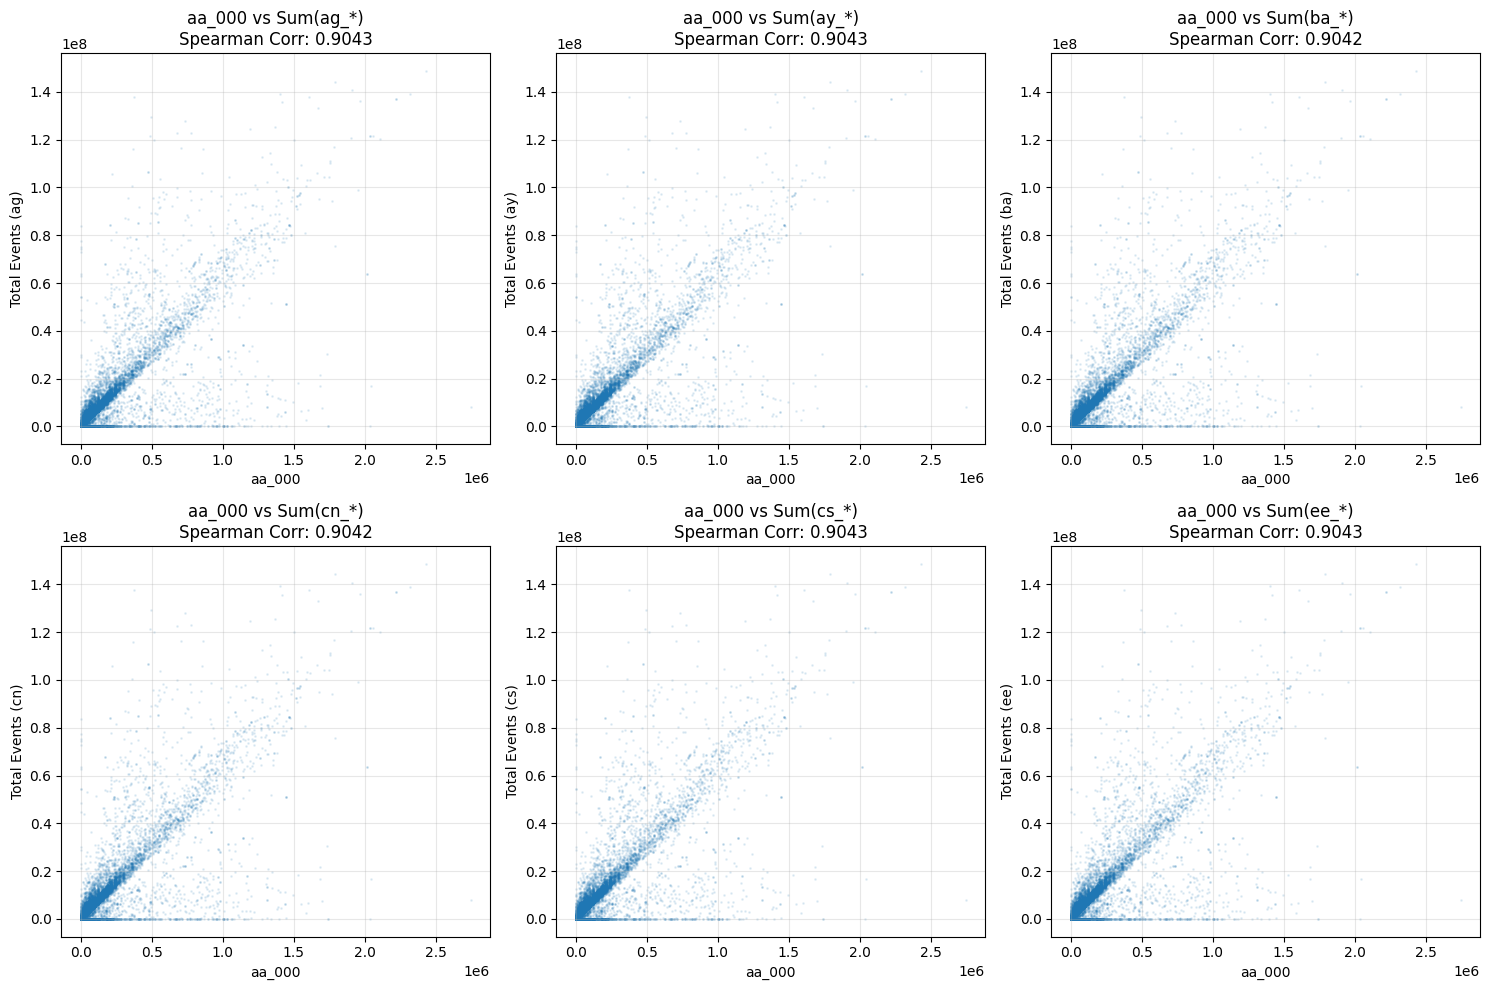


--- Top 10 Features Correlated with aa_000 ---


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


aa_000    1.000000
bt_000    0.999990
ci_000    0.978614
an_000    0.960843
bg_000    0.960597
ah_000    0.960586
ao_000    0.959924
bb_000    0.955651
bu_000    0.955648
cq_000    0.955648
bv_000    0.955648
dtype: float64

--- Class Distribution by aa_000 ---


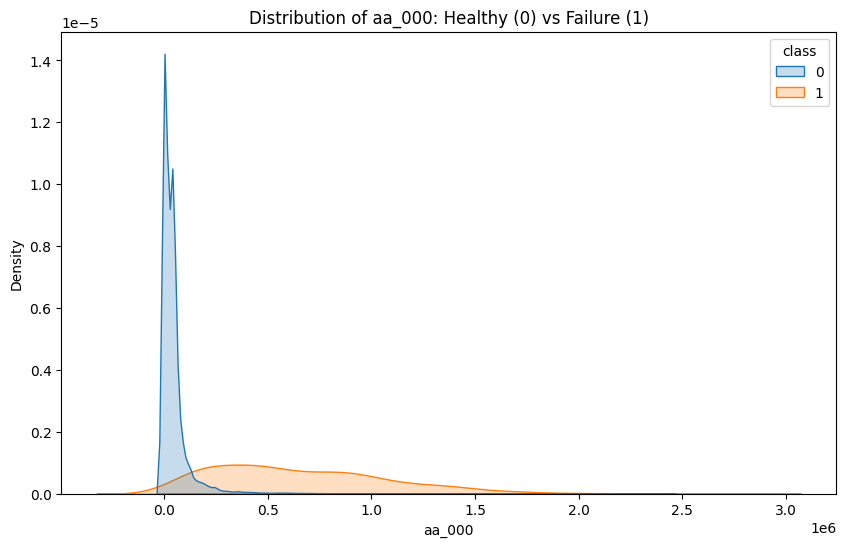

         count           mean            std  min       25%       50%  \
class                                                                   
0      58999.0   49160.331429  110029.541506  0.0     784.0   30414.0   
1       1000.0  659173.664000  434383.878466  0.0  318157.5  584994.0   

            75%        max  
class                       
0       45492.0  2434708.0  
1      930501.5  2746564.0  


In [7]:
analyze_feature_relationships(X_raw, y_raw, reference_col='aa_000')


=== Analysis for Reference Column: ci_000 ===


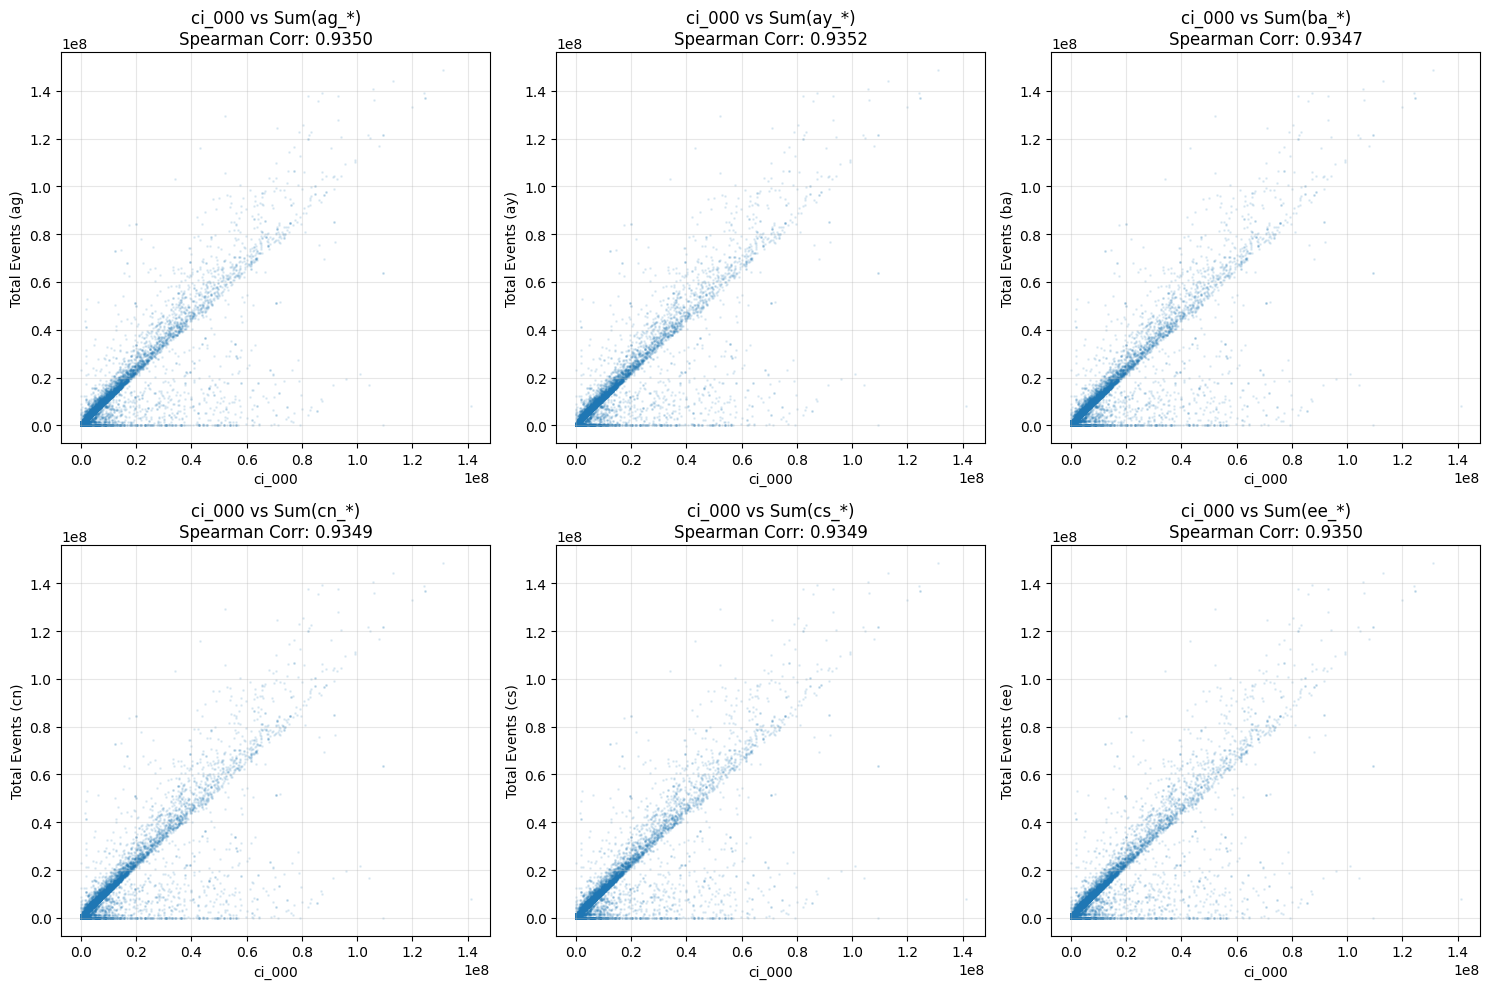


--- Top 10 Features Correlated with ci_000 ---
ci_000    1.000000
bt_000    0.979028
aa_000    0.976064
bg_000    0.975113
ah_000    0.974967
an_000    0.974477
bb_000    0.971386
cq_000    0.970830
bu_000    0.970830
bv_000    0.970830
ao_000    0.969598
dtype: float64

--- Class Distribution by ci_000 ---


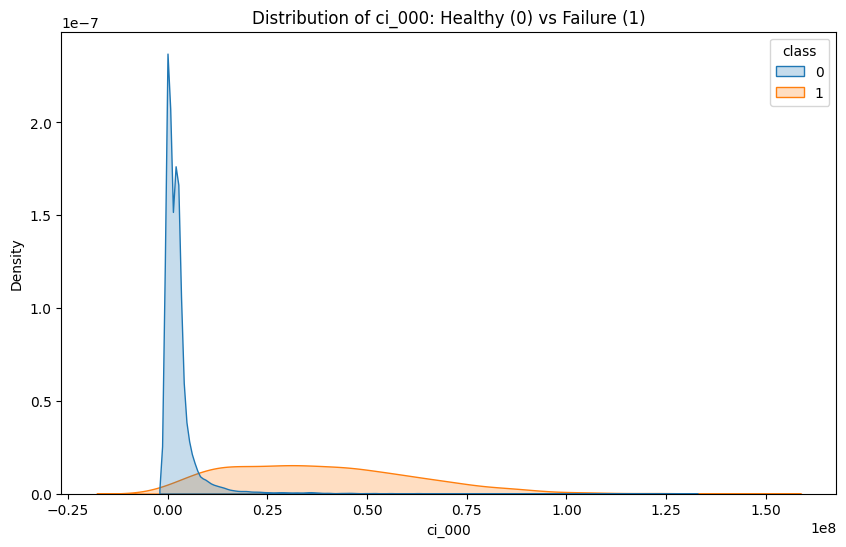

         count          mean           std      min          25%          50%  \
class                                                                           
0      58999.0  2.874413e+06  6.299395e+06     0.00     46202.40   1835494.08   
1       1000.0  3.870163e+07  2.372318e+07  3915.84  19768277.52  35874037.92   

               75%           max  
class                             
0       2820476.64  1.308788e+08  
1      54275865.84  1.409861e+08  


In [16]:
analyze_feature_relationships(X_raw, y_raw, reference_col='ci_000')


=== Analysis for Reference Column: ay_002 ===


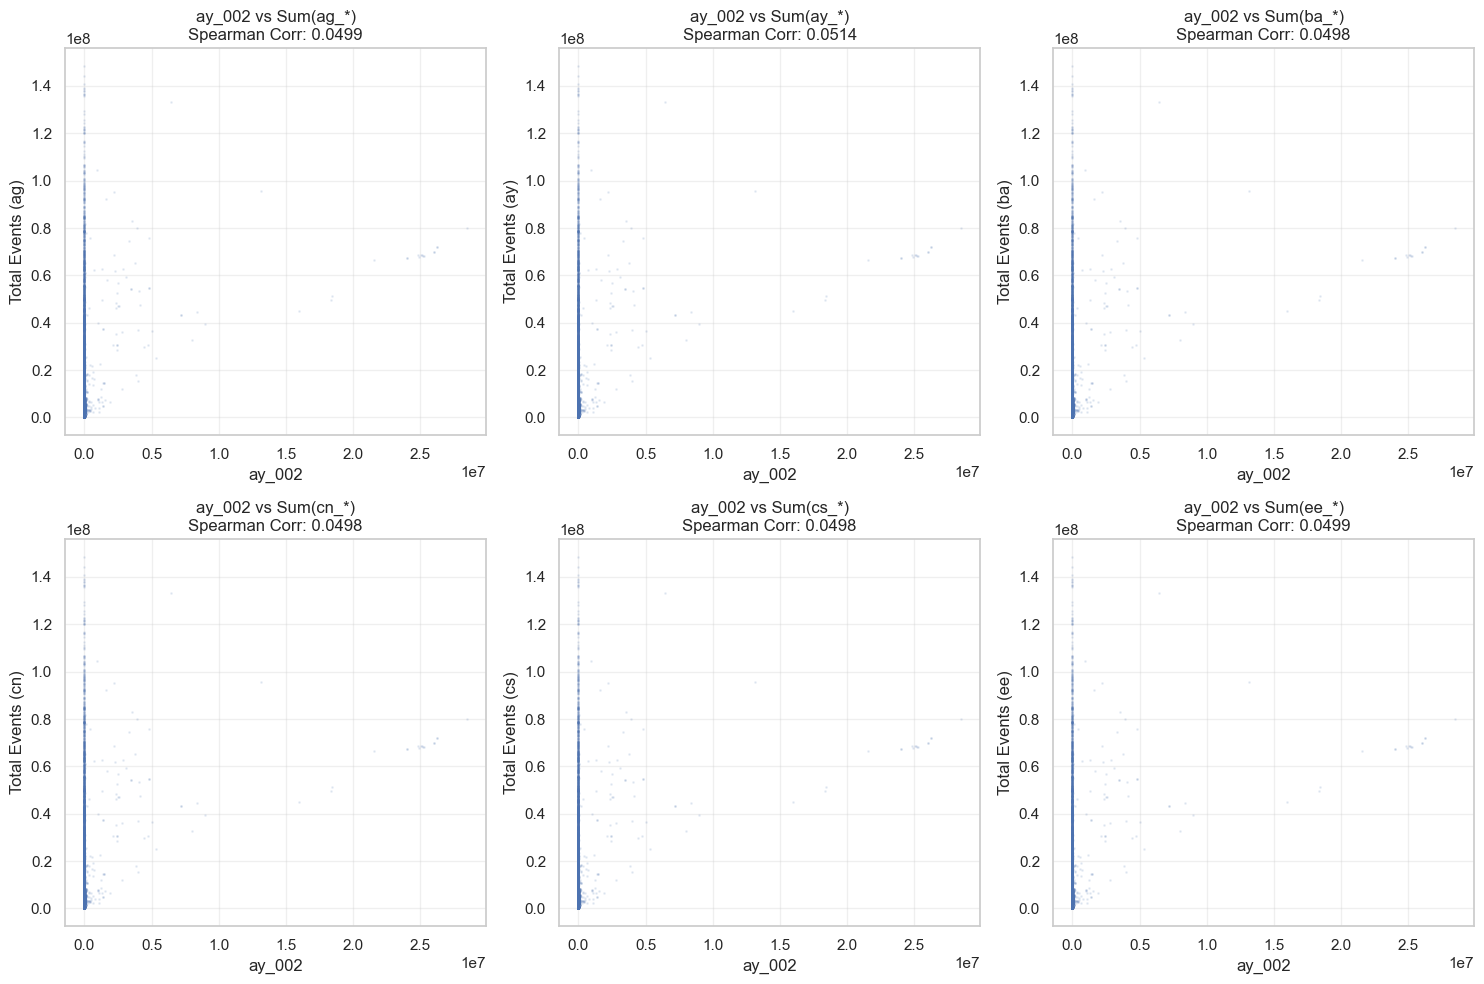


--- Top 10 Features Correlated with ay_002 ---
ay_002    1.000000
ay_001    0.986879
ay_003    0.963407
ay_004    0.731345
ay_000    0.664332
ay_005    0.159669
eb_000    0.148135
ag_003    0.133294
cn_003    0.132706
ag_004    0.132489
cn_002    0.124464
dtype: float64

--- Class Distribution by ay_002 ---


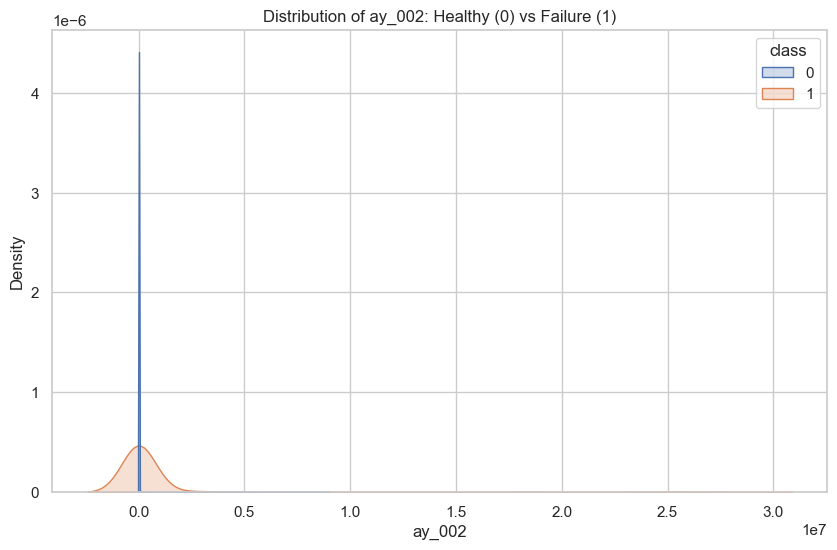

         count           mean           std  min  25%  50%  75%         max
class                                                                      
0      58999.0    1693.982135  7.846655e+04  0.0  0.0  0.0  0.0   8959068.0
1       1000.0  551192.404000  3.199251e+06  0.0  0.0  0.0  0.0  28474838.0


In [84]:
analyze_feature_relationships(X_raw, y_raw, reference_col='ay_002')


=== Analysis for Reference Column: ay_000 ===


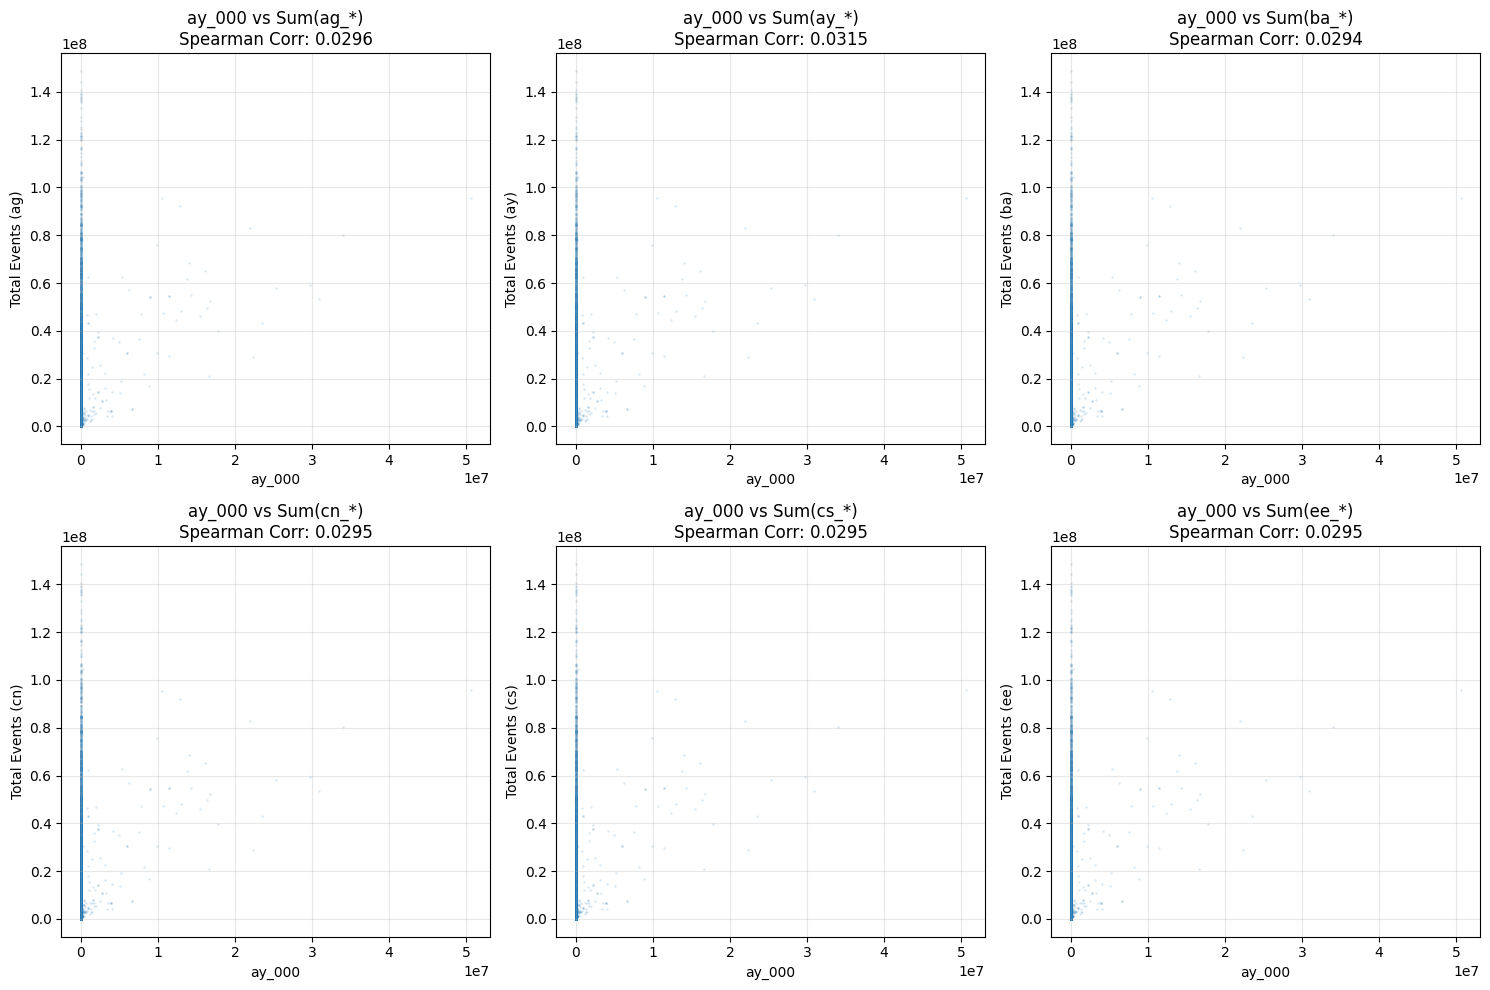


--- Top 10 Features Correlated with ay_000 ---
ay_000               1.000000
ay_001               0.676329
ay_002               0.664332
ay_003               0.642078
ay_004               0.482981
ay_005               0.121830
cx_000_is_missing    0.117371
cy_000_is_missing    0.117371
cv_000_is_missing    0.117371
cu_000_is_missing    0.117371
ct_000_is_missing    0.117371
dtype: float64

--- Class Distribution by ay_000 ---


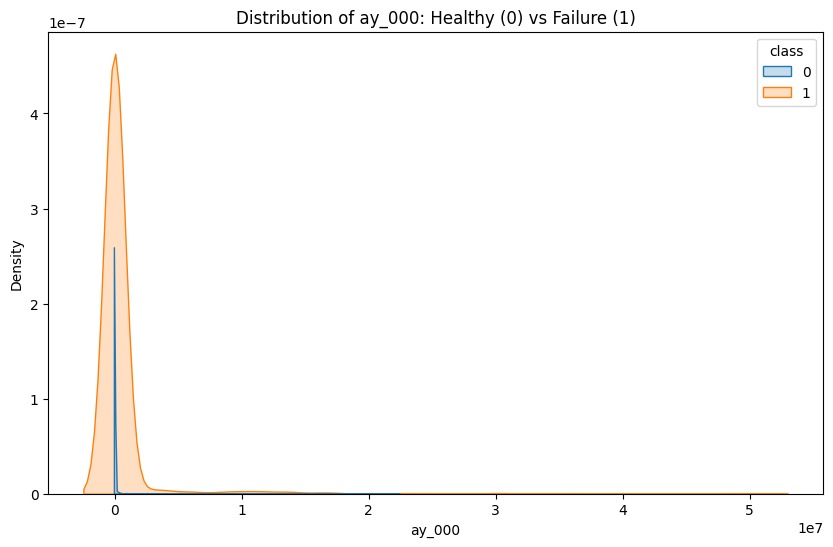

         count           mean           std  min  25%  50%  75%         max
class                                                                      
0      58999.0    2854.934321  1.526242e+05  0.0  0.0  0.0  0.0  22403604.0
1       1000.0  556056.000000  3.254328e+06  0.0  0.0  0.0  0.0  50553892.0


In [18]:
analyze_feature_relationships(X_raw, y_raw, reference_col='ay_000')


=== Analysis for Reference Column: dg_000 ===


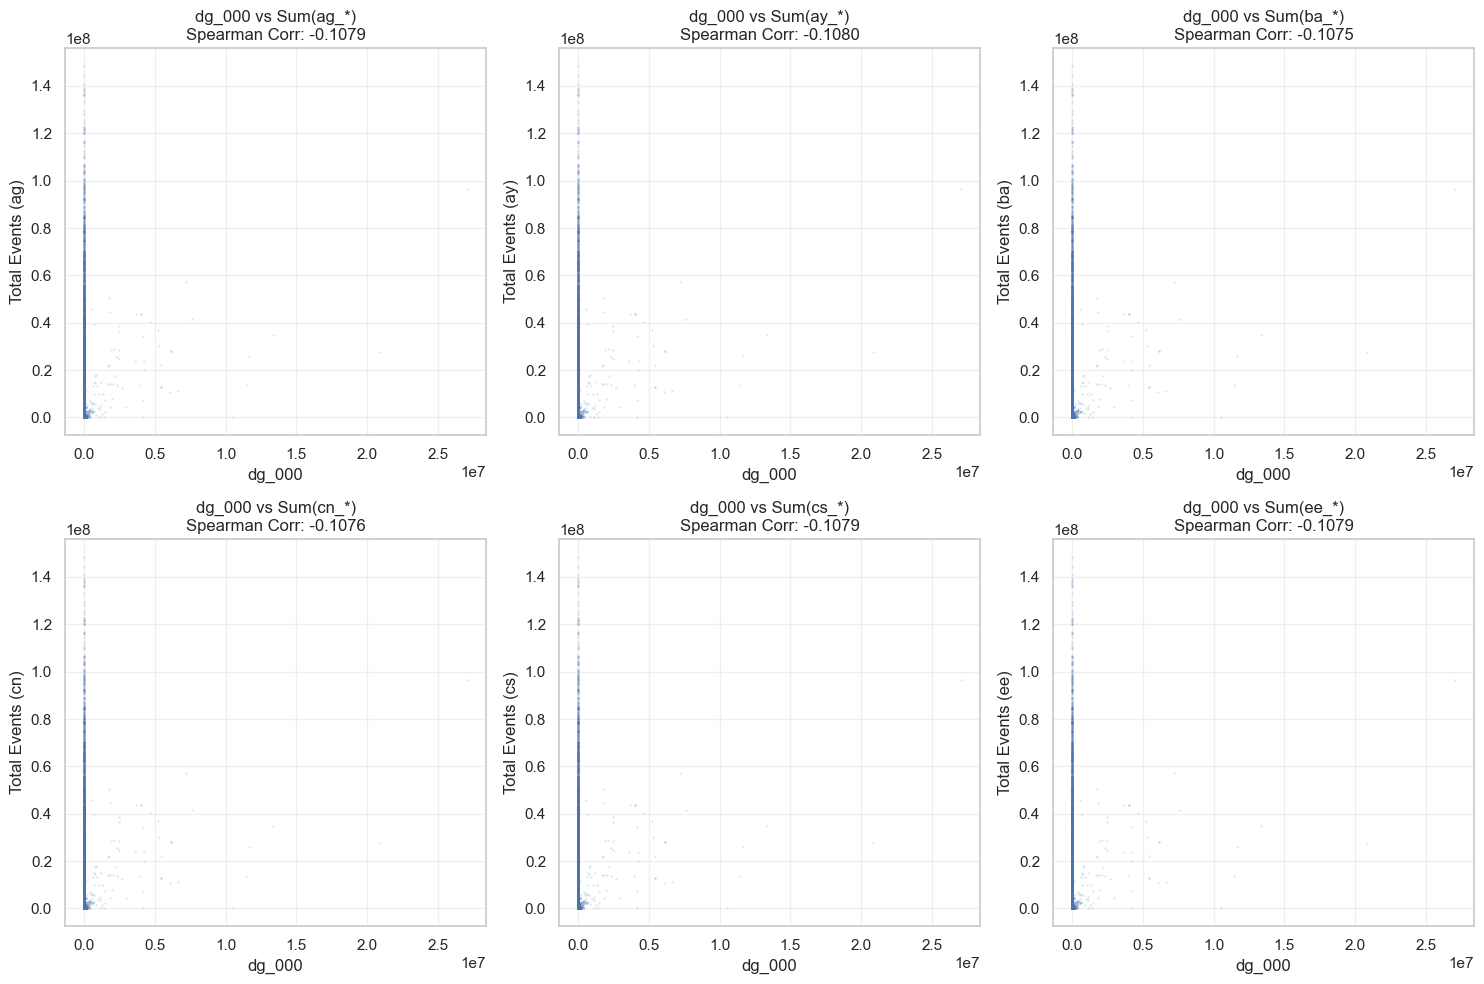


--- Top 10 Features Correlated with dg_000 ---
dg_000               1.000000
df_000               0.823692
cj_000               0.289563
ay_006               0.196103
bz_000               0.160760
ag_007               0.159252
bk_000_is_missing    0.155279
ay_005               0.146549
cn_001               0.144551
cs_006               0.143744
cs_007               0.141932
dtype: float64

--- Class Distribution by dg_000 ---


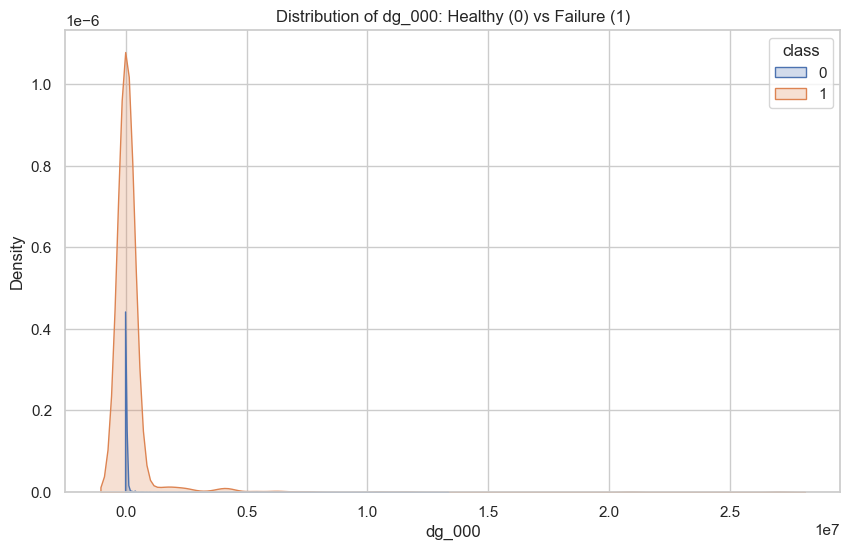

         count           mean           std  min  25%  50%  75%         max
class                                                                      
0      58999.0    1775.219851  8.819369e+04  0.0  0.0  0.0  0.0  13315810.0
1       1000.0  209376.518000  1.391528e+06  0.0  0.0  0.0  0.0  27064294.0


In [85]:
analyze_feature_relationships(X_raw, y_raw, reference_col='dg_000')


=== Analysis for Reference Column: cb_000 ===


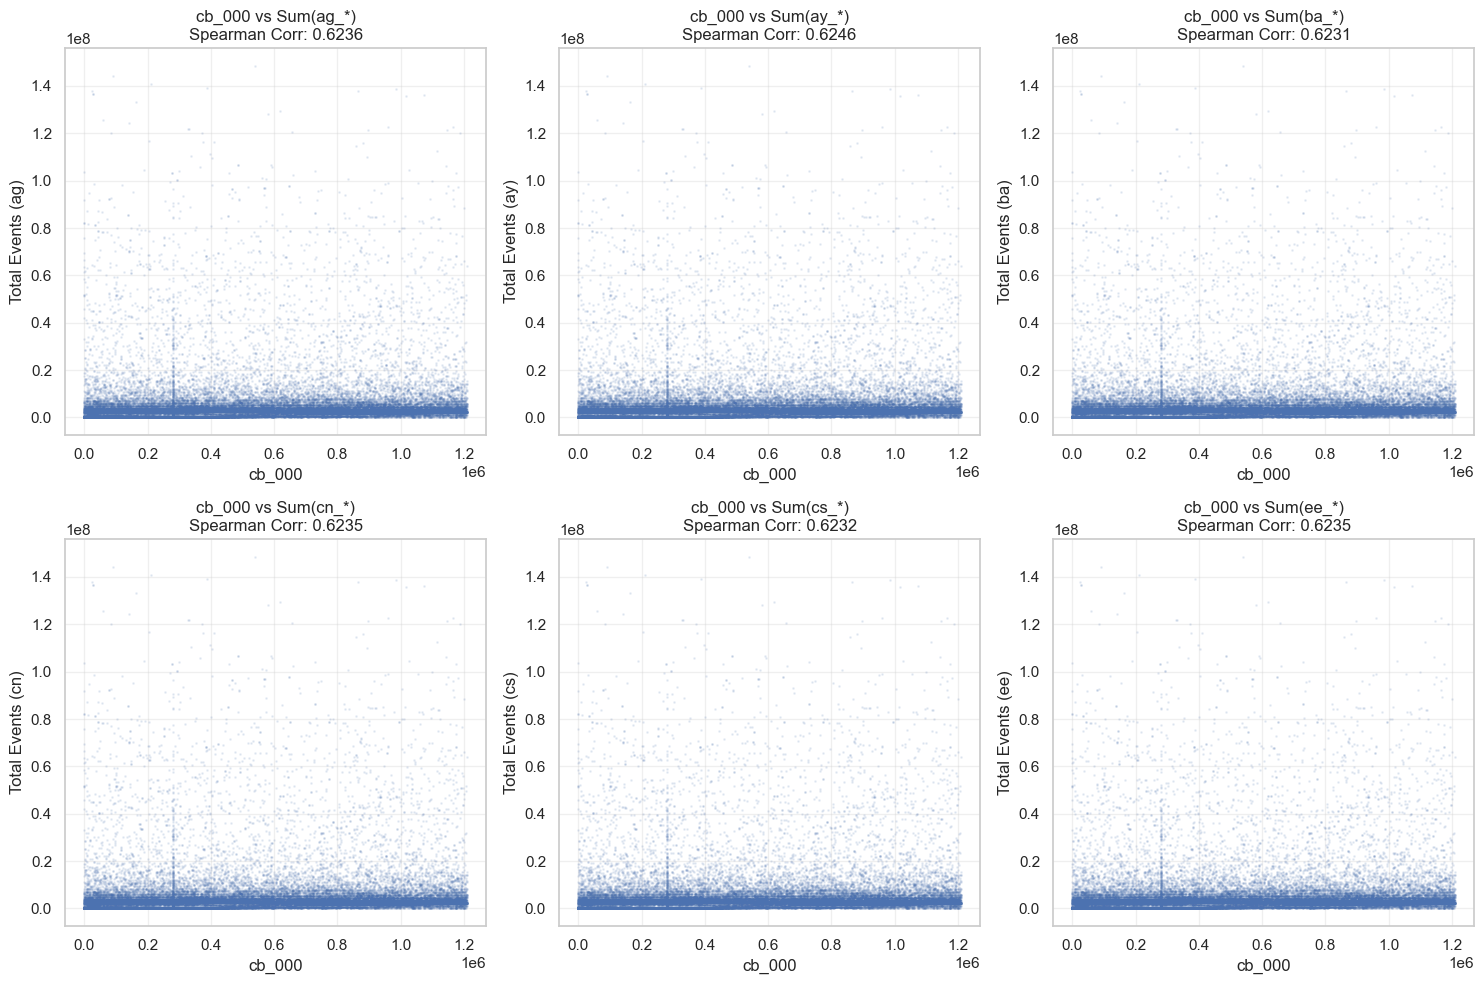


--- Top 10 Features Correlated with cb_000 ---
cb_000    1.000000
bs_000    0.915162
ca_000    0.857444
bu_000    0.670618
bv_000    0.670618
cq_000    0.670618
bb_000    0.669984
dn_000    0.668546
bj_000    0.667018
bh_000    0.666275
an_000    0.664495
dtype: float64

--- Class Distribution by cb_000 ---


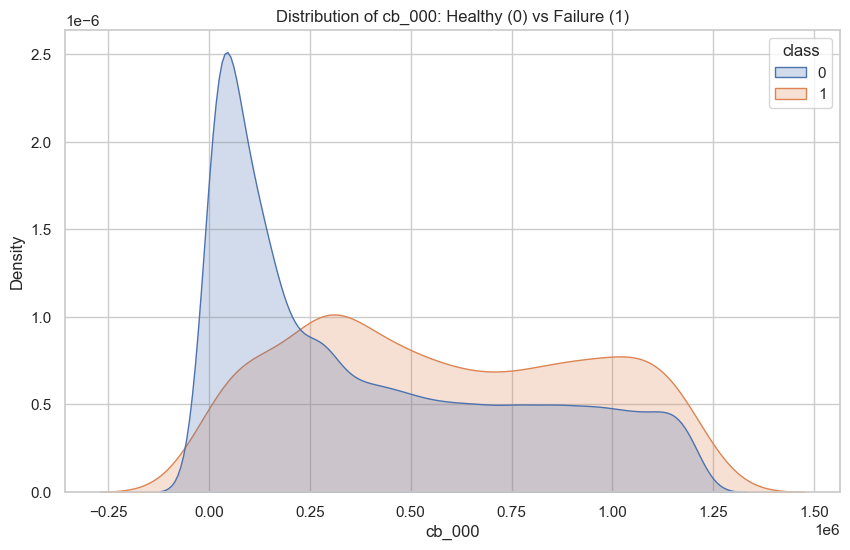

         count           mean            std  min       25%       50%  \
class                                                                   
0      58999.0  401133.781251  366855.902407  0.0   77290.0  278960.0   
1       1000.0  578794.300000  357295.175793  0.0  278960.0  548940.0   

            75%        max  
class                       
0      694280.0  1209520.0  
1      897255.0  1207560.0  


In [86]:
analyze_feature_relationships(X_raw, y_raw, reference_col='cb_000')


=== Analysis for Reference Column: bs_000 ===


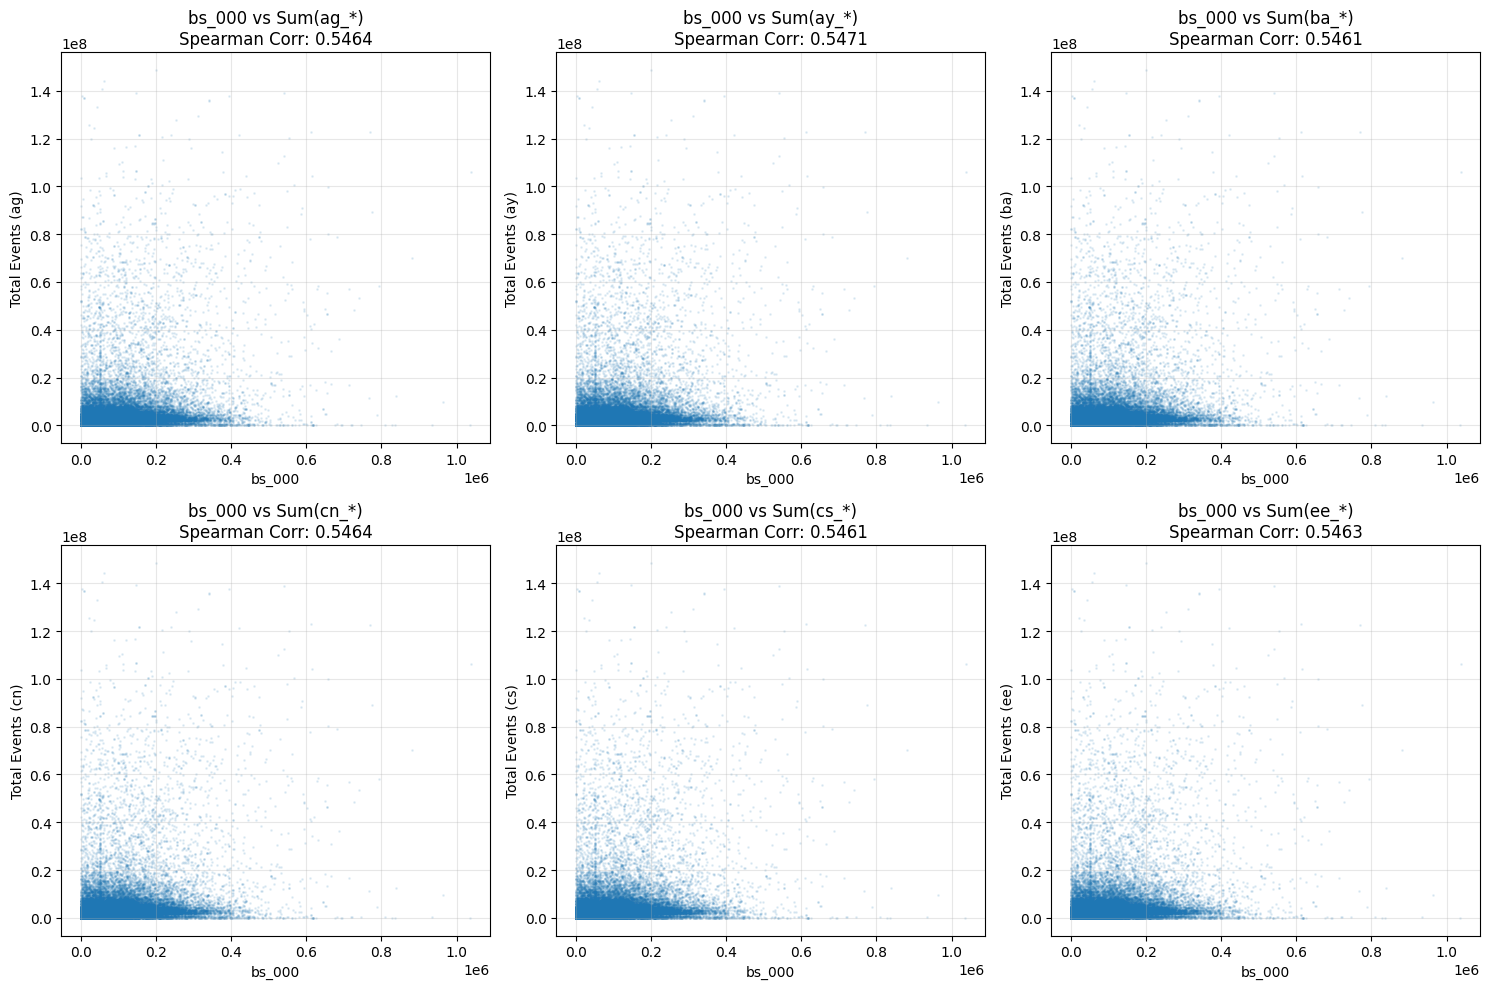


--- Top 10 Features Correlated with bs_000 ---
bs_000    1.000000
cb_000    0.915162
ca_000    0.767794
ap_000    0.676935
bi_000    0.666583
bj_000    0.648259
dn_000    0.635774
aq_000    0.625851
bh_000    0.617215
bv_000    0.611006
cq_000    0.611006
dtype: float64

--- Class Distribution by bs_000 ---


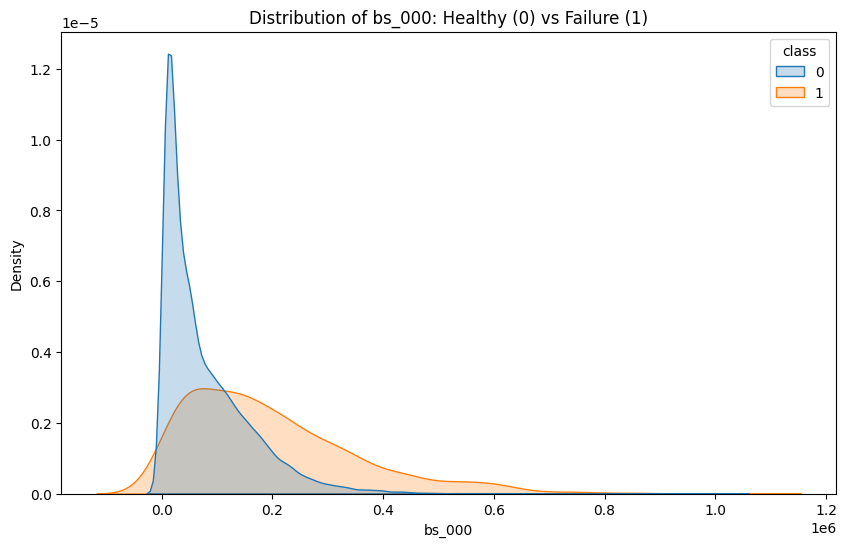

         count           mean            std  min      25%       50%  \
class                                                                  
0      58999.0   78007.382498   80843.814411  0.0  17290.0   50540.0   
1       1000.0  197391.800000  156143.152170  0.0  72780.0  162990.0   

            75%        max  
class                       
0      115560.0  1034620.0  
1      278385.0  1037240.0  


In [19]:
analyze_feature_relationships(X_raw, y_raw, reference_col='bs_000')


=== Analysis for Reference Column: ag_002 ===


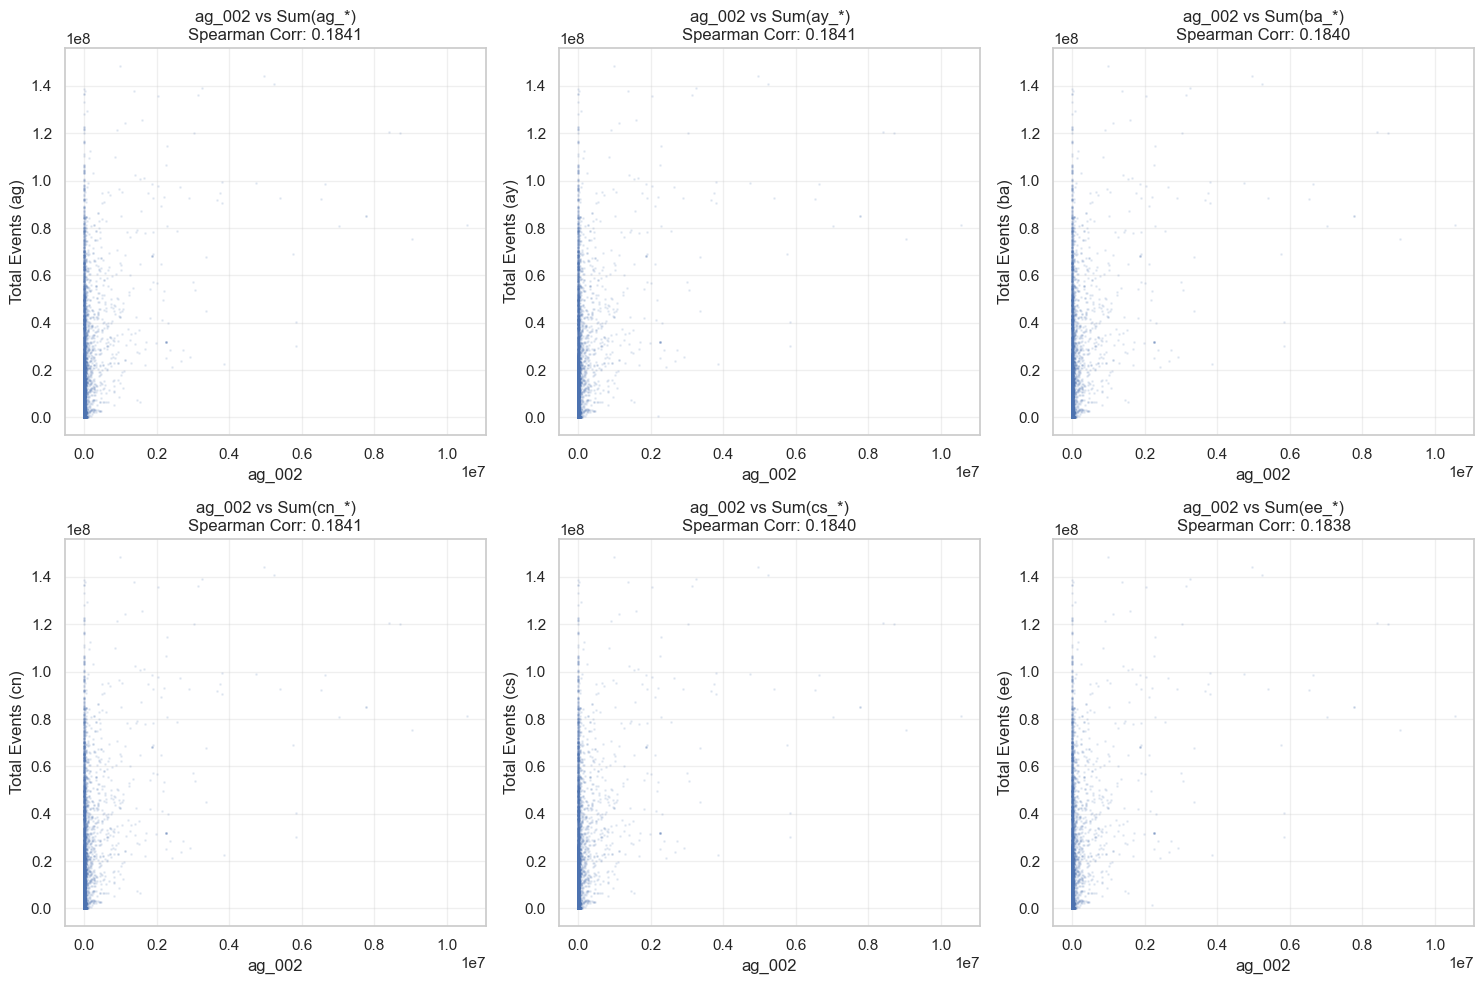


--- Top 10 Features Correlated with ag_002 ---
ag_002    1.000000
cn_000    0.779944
cn_001    0.595659
ag_003    0.524665
ag_001    0.489754
al_000    0.386002
am_0      0.385927
cn_002    0.370500
ar_000    0.355048
ba_009    0.325675
ag_004    0.318555
dtype: float64

--- Class Distribution by ag_002 ---


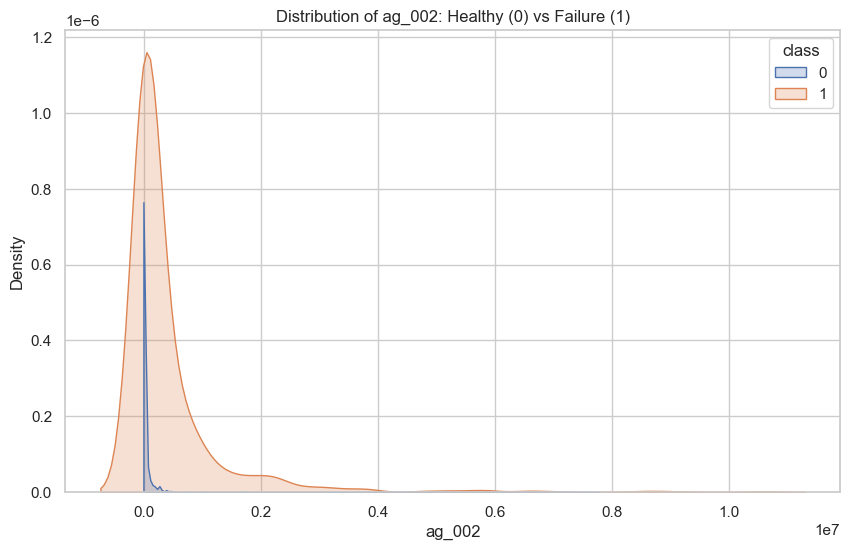

         count           mean            std  min  25%     50%       75%  \
class                                                                      
0      58999.0    1786.762555   50472.870472  0.0  0.0     0.0       0.0   
1       1000.0  398840.840000  998199.299191  0.0  0.0  1942.0  367493.0   

              max  
class              
0       7771682.0  
1      10552856.0  


In [90]:
analyze_feature_relationships(X_raw, y_raw, reference_col='ag_002')


=== Analysis for Reference Column: bk_000 ===


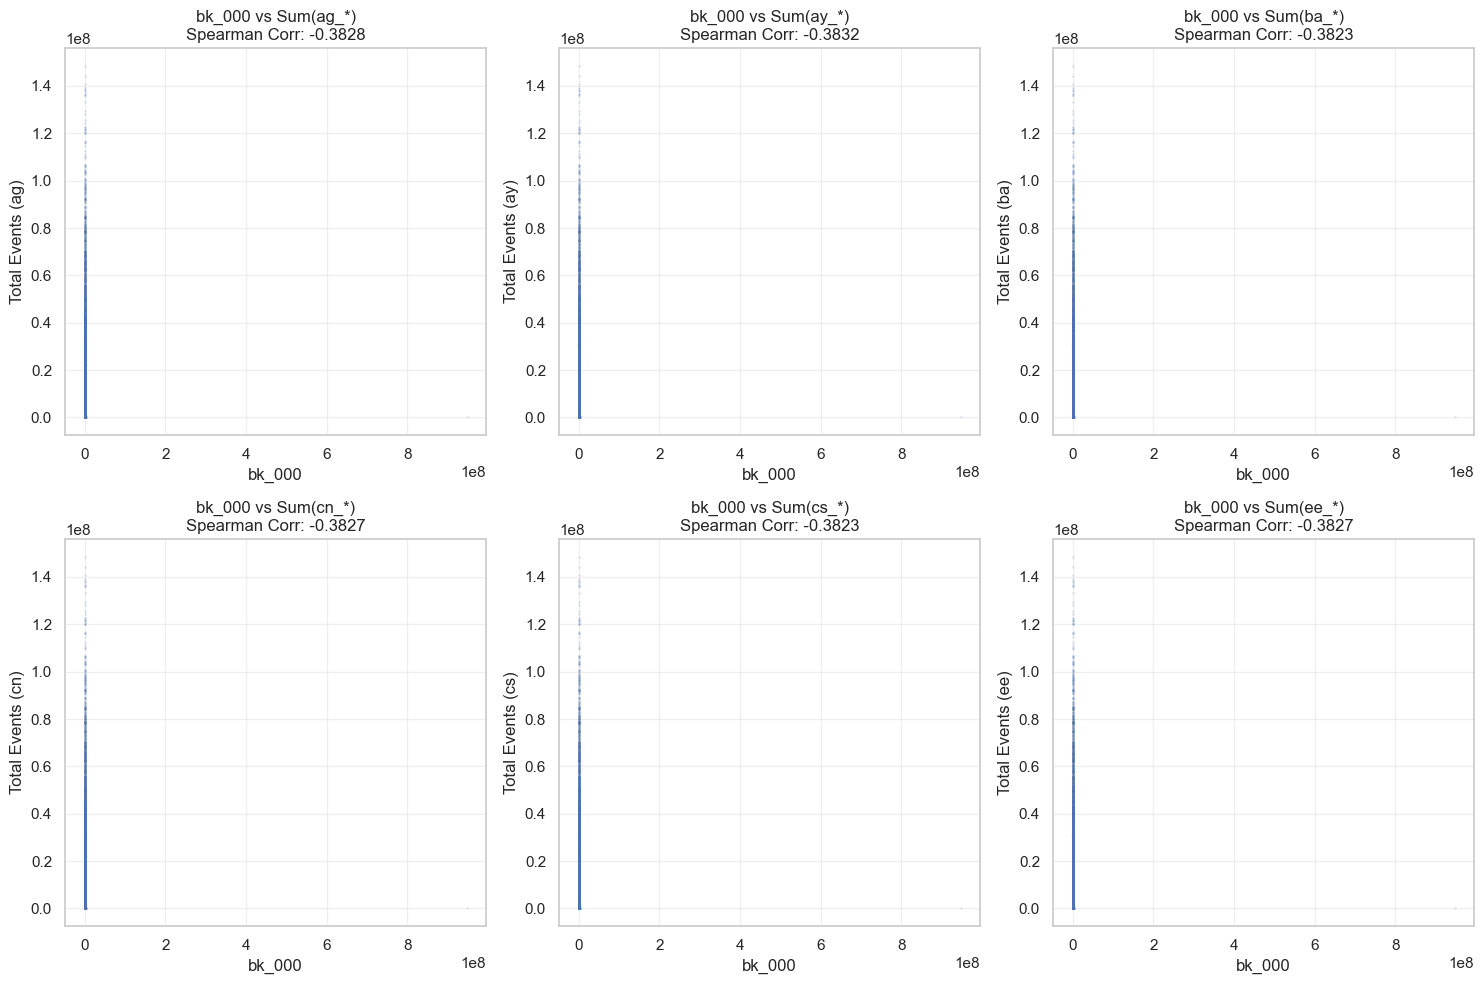


--- Top 10 Features Correlated with bk_000 ---
bk_000               1.000000
bl_000               0.792770
bm_000               0.704674
ee_008               0.488738
do_000               0.483493
dp_000               0.479267
ee_009               0.467167
bk_000_is_missing    0.459011
ay_006               0.457346
ao_000               0.444061
ag_007               0.432966
dtype: float64

--- Class Distribution by bk_000 ---


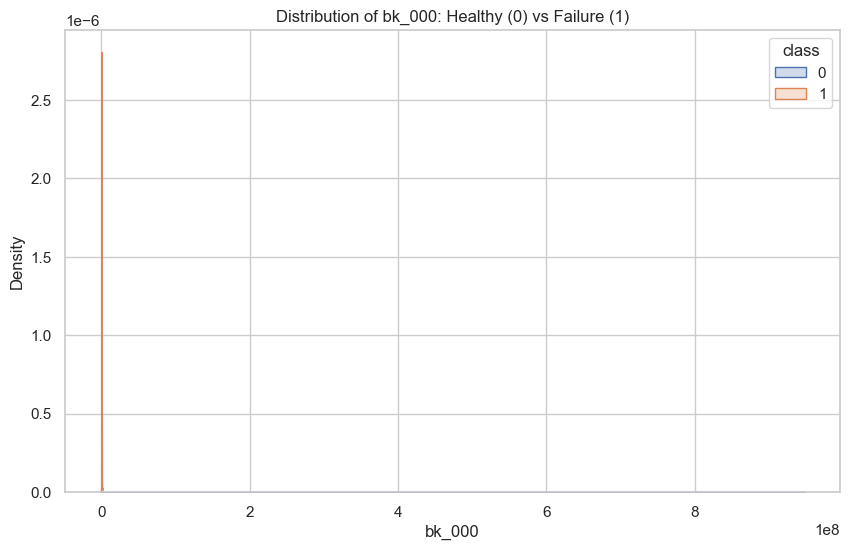

         count           mean           std            min       25%  \
class                                                                  
0      58999.0  300017.483186  3.904684e+06  -61786.726767  190560.0   
1       1000.0  388121.106305  1.897584e+05 -803258.956800  263475.0   

                 50%            75%           max  
class                                              
0      284600.661357  292277.851370  9.473722e+08  
1      342850.000000  483443.833503  1.310700e+06  


In [91]:
analyze_feature_relationships(X_raw, y_raw, reference_col='bk_000')


=== Analysis for Reference Column: ag_009 ===


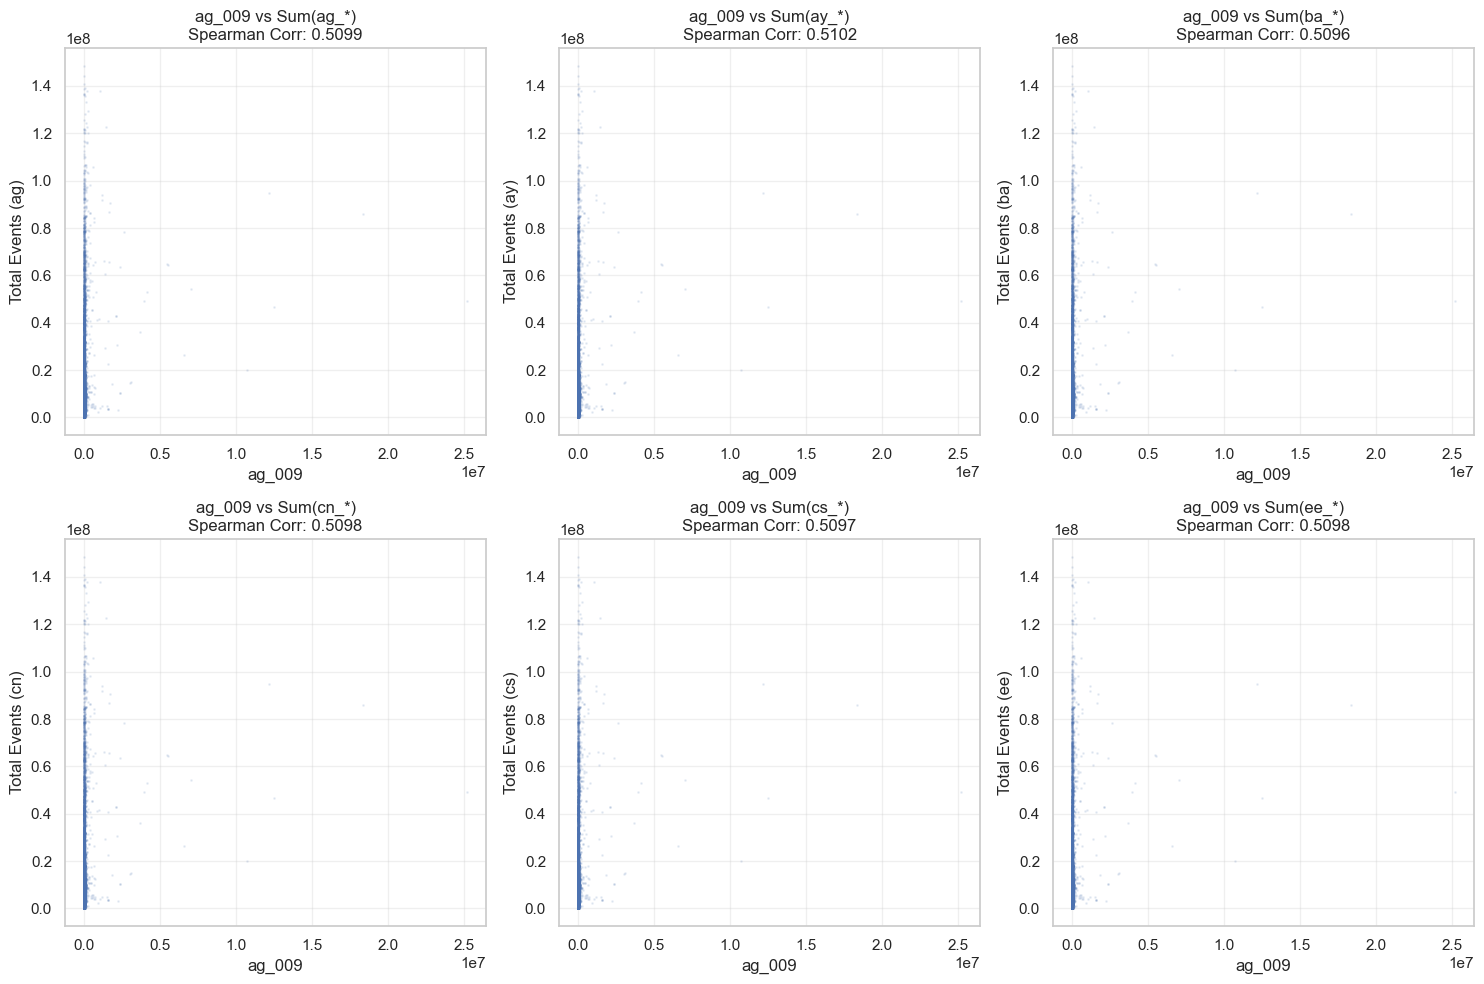


--- Top 10 Features Correlated with ag_009 ---
ag_009    1.000000
ag_008    0.772241
ag_007    0.641278
cn_006    0.611984
cn_005    0.575992
ba_007    0.570980
az_003    0.566757
cn_009    0.558393
by_000    0.557854
cn_007    0.556492
ag_006    0.542509
dtype: float64

--- Class Distribution by ag_009 ---


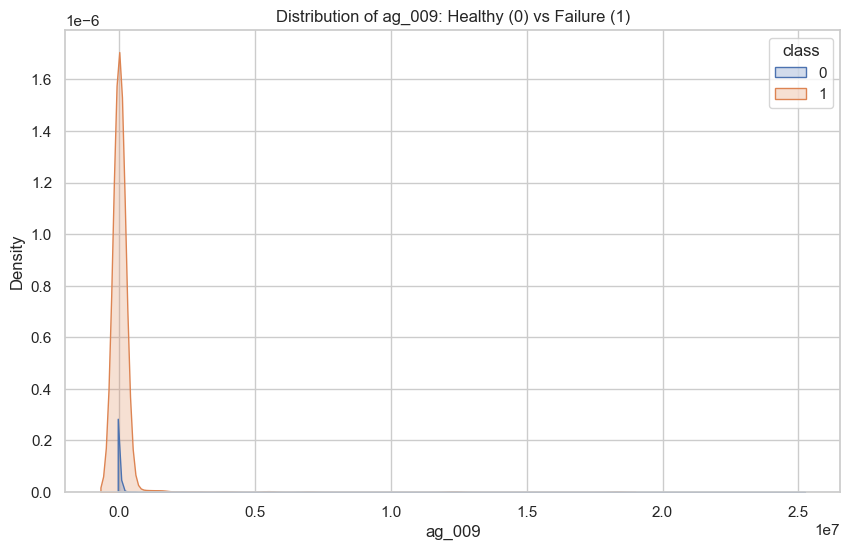

         count          mean            std  min  25%   50%     75%  \
class                                                                 
0      58999.0   3472.970186  122853.022699  0.0  0.0   0.0   312.0   
1       1000.0  98464.742000  899549.251198  0.0  0.0  18.0  2718.0   

              max  
class              
0      25198514.0  
1      18336298.0  


In [87]:
analyze_feature_relationships(X_raw, y_raw, reference_col='ag_009')


=== Analysis for Reference Column: co_000 ===


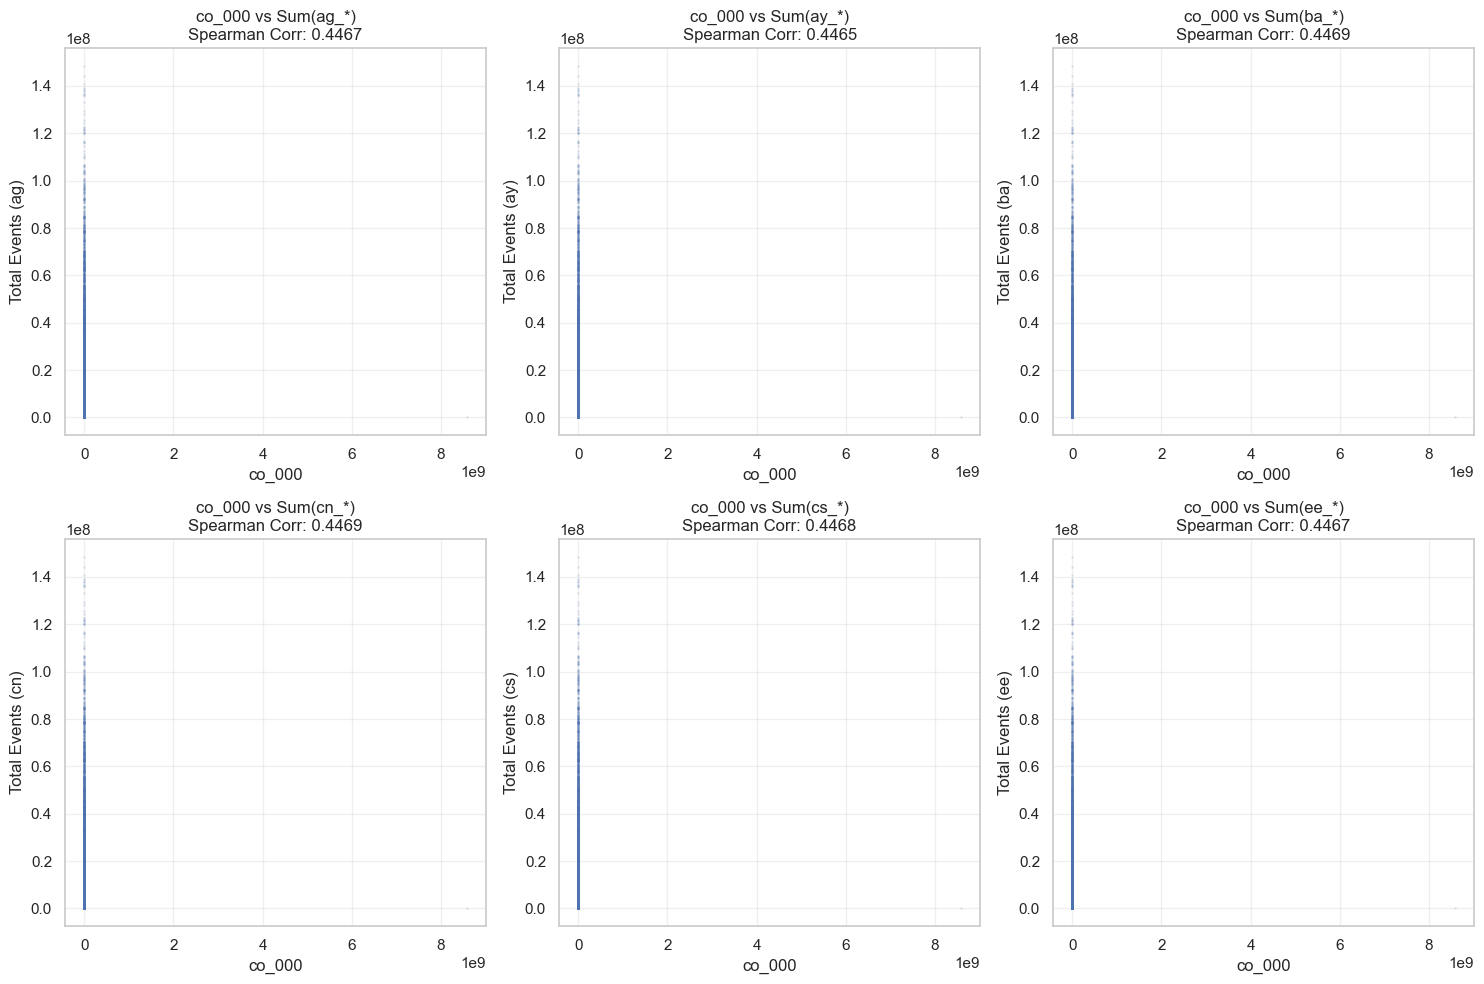


--- Top 10 Features Correlated with co_000 ---
co_000               1.000000
ad_000               0.820916
co_000_is_missing    0.751376
cg_000_is_missing    0.751376
ad_000_is_missing    0.751376
ch_000_is_missing    0.751376
cf_000_is_missing    0.751376
da_000_is_missing    0.710676
cz_000_is_missing    0.710676
cy_000_is_missing    0.710676
dc_000_is_missing    0.710676
dtype: float64

--- Class Distribution by co_000 ---


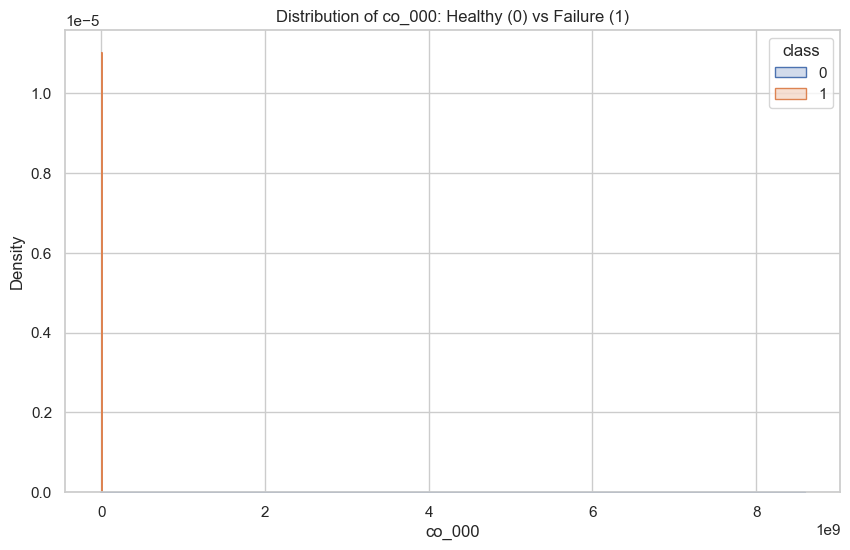

         count           mean           std  min    25%           50%  \
class                                                                   
0      58999.0  191677.881318  3.534120e+07  0.0    2.0      28.00000   
1       1000.0  125923.952024  9.172087e+04  0.0  861.0  190489.55433   

                 75%           max  
class                               
0        4604.000000  8.584298e+09  
1      192373.612909  3.173780e+05  


In [88]:
analyze_feature_relationships(X_raw, y_raw, reference_col='co_000')


=== Analysis for Reference Column: ai_000 ===


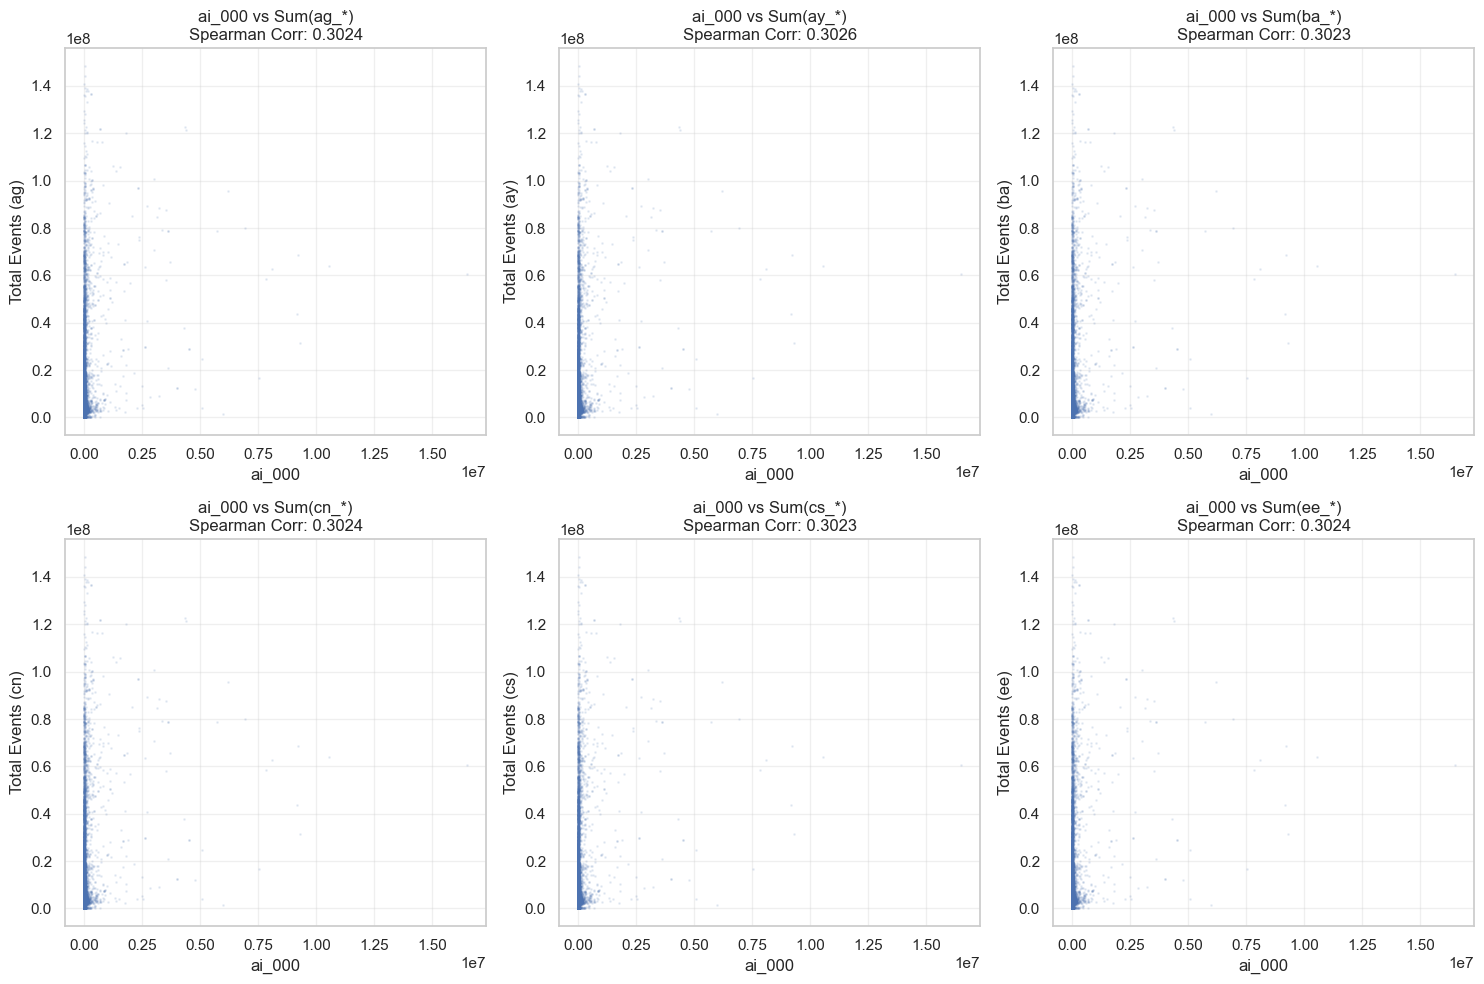


--- Top 10 Features Correlated with ai_000 ---
ai_000    1.000000
bj_000    0.382484
aq_000    0.375167
ap_000    0.364150
dn_000    0.363845
bh_000    0.349362
ck_000    0.337198
bi_000    0.332741
bb_000    0.321590
ah_000    0.320805
bu_000    0.320672
dtype: float64

--- Class Distribution by ai_000 ---


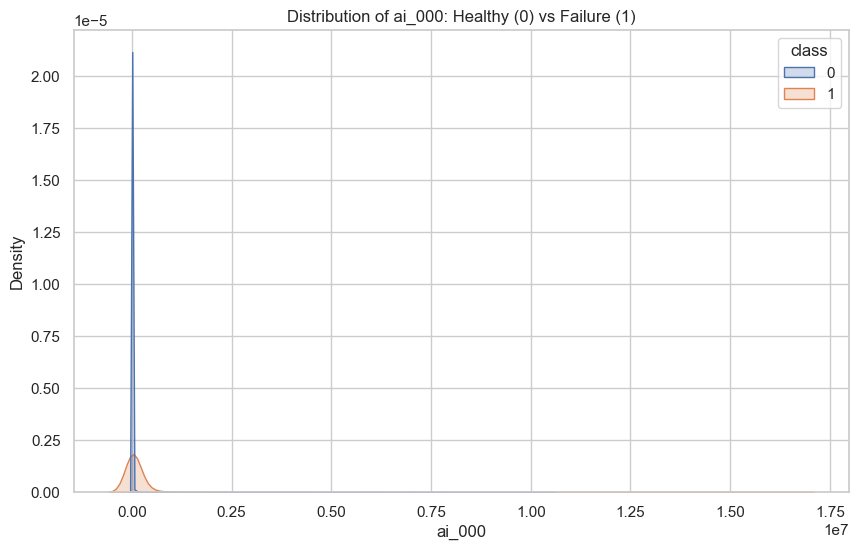

         count           mean            std  min  25%     50%      75%  \
class                                                                     
0      58999.0    6421.613553  128908.596354  0.0  0.0     0.0      0.0   
1       1000.0  156477.476000  762154.004777  0.0  0.0  8456.0  53520.0   

              max  
class              
0      10552482.0  
1      16512852.0  


In [89]:
analyze_feature_relationships(X_raw, y_raw, reference_col='ai_000')


=== Analysis for Reference Column: az_006 ===


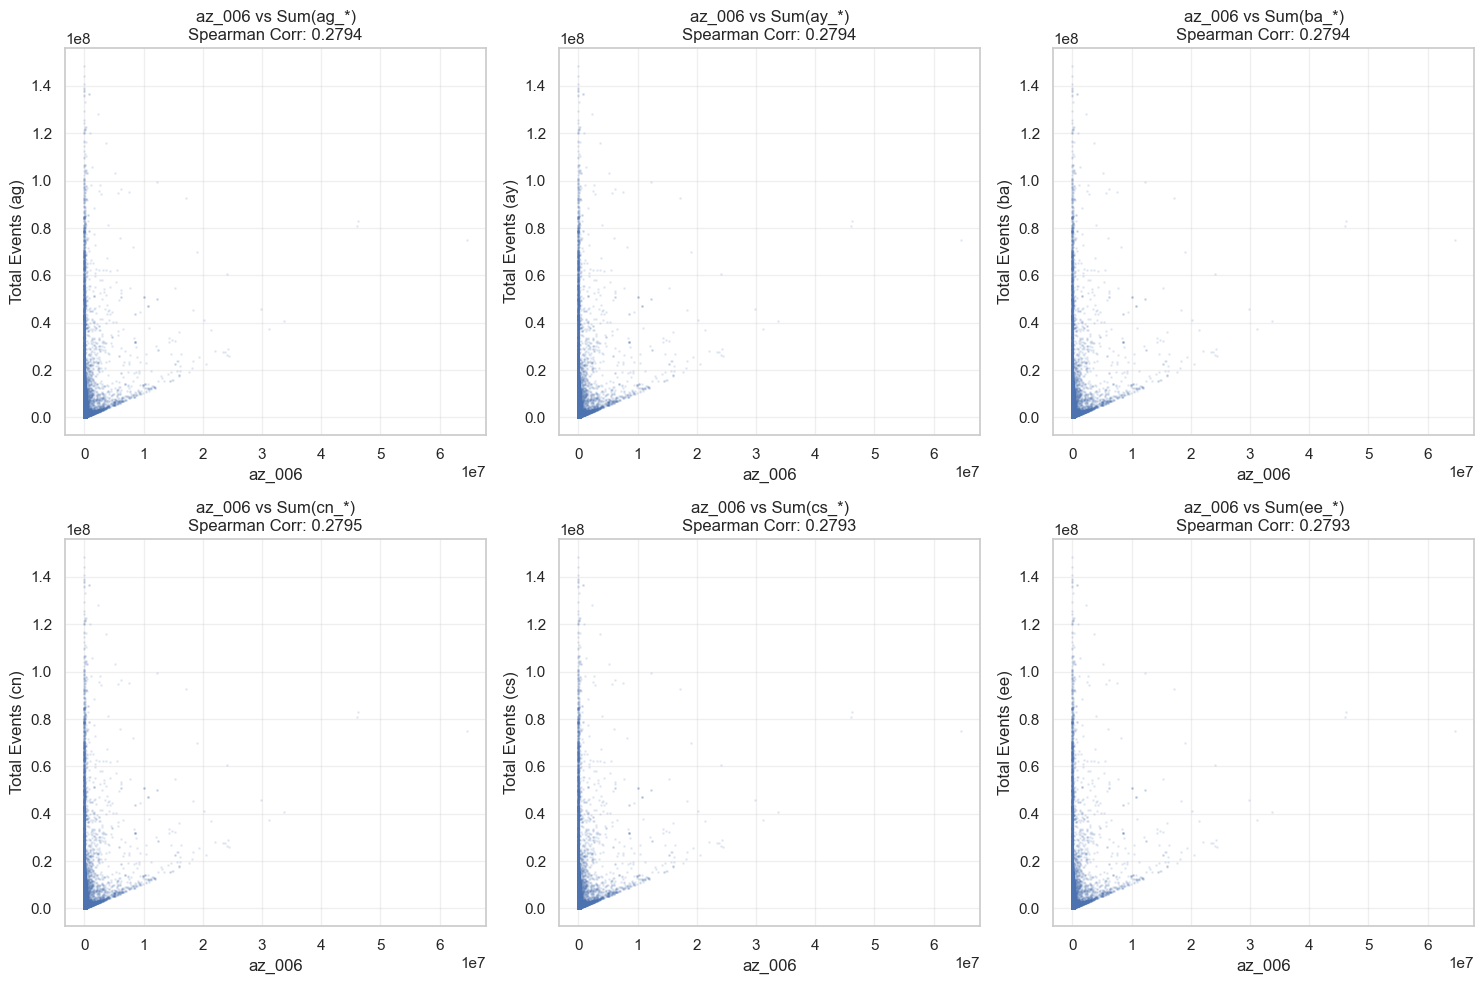


--- Top 10 Features Correlated with az_006 ---
az_006    1.000000
az_007    0.470908
ag_004    0.375731
cn_003    0.345432
ag_005    0.342903
cs_000    0.319921
cs_007    0.310908
ba_005    0.307242
cn_002    0.307118
cs_001    0.304953
ba_006    0.302991
dtype: float64

--- Class Distribution by az_006 ---


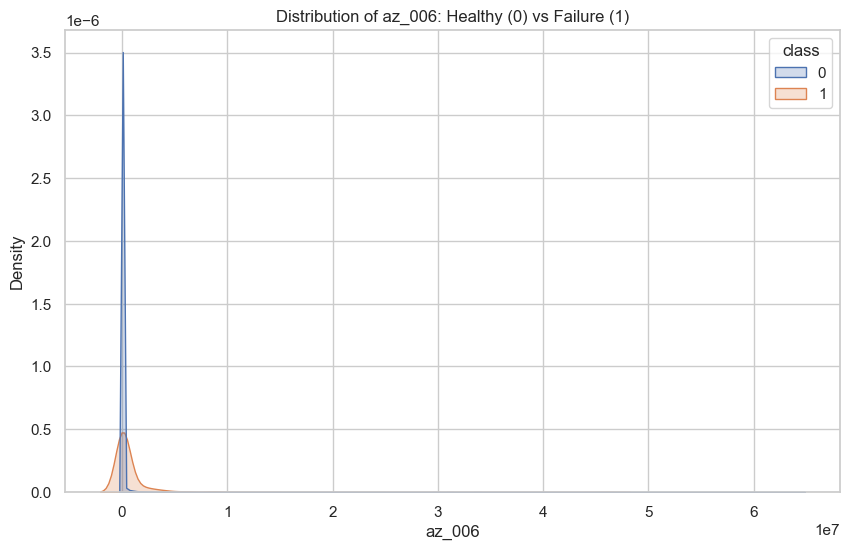

         count           mean           std  min   25%     50%       75%  \
class                                                                      
0      58999.0   89591.236835  7.990099e+05  0.0  10.0   292.0    3982.0   
1       1000.0  710088.588000  2.748007e+06  0.0  10.0  1201.0  213106.0   

              max  
class              
0      64589140.0  
1      46170334.0  


In [92]:
analyze_feature_relationships(X_raw, y_raw, reference_col='az_006')